# Data Preprocessing

Set the environment and variables 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
from datetime import timedelta
import matplotlib.pyplot as plt
import torch

import random
import typing
from collections import Counter
from pathlib import Path
import re

from torch.utils.data import Dataset
from torchtext.vocab import vocab
from torchtext.data.utils import get_tokenizer
from collections import OrderedDict


import itertools
from torch import nn
import torch.nn.functional as f

In [2]:
root_addr = "/nfs/home/aliami/mimic4_dataset/physionet.org/files/mimiciv/2.2/hosp/pre_proc_data/"


In [3]:
import pickle
with open (root_addr+'saved_idx/mimic4_icd9_X_train_3spilit', 'rb') as fp:
    X_train_idx_main = pickle.load(fp)

In [4]:
#read the unique diags and medications lists
uniq_diags = np.load(root_addr+'mimic4_uniq_icd9.npy',allow_pickle='TRUE').tolist()
uniq_meds = np.load(root_addr+'mimic4_uniq_atc5.npy',allow_pickle='TRUE').tolist()
len(uniq_diags), len(uniq_meds), uniq_diags[:5], uniq_meds[:5]

(9072,
 773,
 ['5723', '78959', '5715', '07070', '496'],
 ['N02BE01', 'C03CA01', 'J05AX08', 'S01XA14', 'R03CC02'])

Map the Patient trajectories to text format:

    medical code -> token
    new visit -> dot
    visit -> sentence
    patient trajectory -> document
    
output e.g.

    m_N02B d_6103 m_A10A . m_A06A d_3485 m_A04 . m_N02A m_V04C
    
For the interpreteability purposes we added d_ before ICD9 codes and m_ before ATC5 codes 


In [12]:
def get_selected_ind_dict(inp_dict, indxs):
    inp_dict = pd.Series(inp_dict) 
    out_dict = {}
    for i in indxs:
        out_dict[inp_dict.index[i]]= inp_dict.iloc[i]
    return out_dict

##load data

# Load dictionary
pat_id_visist_dict = np.load(root_addr+'mimic4_all_pat_icd9_atc5.npy',allow_pickle='TRUE').item()

print(len(pat_id_visist_dict.keys()))
pat_id_visist_dict = get_selected_ind_dict(pat_id_visist_dict, X_train_idx_main)
print(len(pat_id_visist_dict.keys()))

num_visits = 100

#convert key-value dataset to visit_seq dataframe
def make_historical_dataframe(patient_diagnosis_dict, num_visit_per_patient=num_visits, target_icd9_code= "428",
                              zero_padding=False,
                             codes_proc=True): #428
  
  data_disease_df_list = []
  dtarget = "1"
  for key, val in tqdm(patient_diagnosis_dict.items()):
    #reverse the order of visit to have them to have past:furure order
    #because in our preprocessing we put the last visit at the first element of the list
    #The mimic dataset is in the right order and does not need to revse its order
    
    #delete tajectories with only one visit
    if len(val)==1:
        continue
    
    #val = list(reversed(val))
    #truncate to first 4 digits
    visits_seq = []
    if codes_proc:
        for vis in val:
            #visits_seq.append([code[:4] for code in vis])
            visits_seq.append(["d_"+code[:4] if code in uniq_diags else "m_"+code[:4] for code in vis])
        val = visits_seq
    patient_diagnosis_dict[key] = visits_seq
    if len(val) >= num_visit_per_patient:
        data_disease_df_list.append([*val[-num_visit_per_patient:], dtarget, key])
    else:
        if zero_padding:
            num_of_zero_cols = -(len(val) - num_visit_per_patient)
            temp_list = [["empty"] for i in range(num_of_zero_cols)]
            data_disease_df_list.append([*temp_list,*val, dtarget, key])
            
  col_names = ["visit"+str(i) for i in range(1,num_visit_per_patient+1)] + ["target"] + ["patient_id"]
  data_disease_df = pd.DataFrame(data_disease_df_list, columns=col_names)
  return data_disease_df, patient_diagnosis_dict




data_disease_df, pat_id_visist_dict_x = make_historical_dataframe(pat_id_visist_dict,
                                                                num_visit_per_patient=num_visits,
                                                                zero_padding=True)
data_disease_df

#convert  visit_seq dataframe of visits to sequences of sentences
#word=code, visit=sentence
def visit_sec_to_sen_seq(vis_seq_df, number_of_visits=num_visits, duplicate_allowed = True):
    vis_seq_df = (vis_seq_df.iloc[:,0:number_of_visits])
    vis_seq_str_list = []
    for index, row in vis_seq_df.iterrows():
        #delete empty visits
        if not duplicate_allowed:
            row = pd.Series([list(set(visit)) for visit in row])
        row = list(filter(lambda a: a != ["empty"], row.tolist()))
        seq_sen = " . ".join([" ".join(vis) for vis in row])
        vis_seq_str_list.append(seq_sen)
    return vis_seq_str_list#pd.DataFrame(vis_seq_str_list).astype(str)


vis_seq_df_str = visit_sec_to_sen_seq(data_disease_df, duplicate_allowed=False)
#vis_seq_df_str



172980
121086


100%|██████████████████████████████████| 121086/121086 [06:30<00:00, 309.86it/s]


In [5]:
#load
vis_seq_df_str = np.load(root_addr+'mimic4_icd9_atc5_long_100vis_seq_df_str.npy',allow_pickle='TRUE').tolist()

Spliting data to train and test

In [6]:
from sklearn.model_selection import train_test_split

X_train_idx, X_test_idx, y_train_idx, y_test_idx = train_test_split(range(len(vis_seq_df_str)),
                                                    range(len(vis_seq_df_str)),
                                                    test_size=0.10,
                                                    random_state=999)

len(X_train_idx), len(X_test_idx)

(47548, 5284)

In [7]:
#make train and test data based on their indexes
X_train, X_val = list(np.array(vis_seq_df_str)[X_train_idx]), list(np.array(vis_seq_df_str)[X_test_idx])


len(X_train), len(X_val)

(47548, 5284)

In [8]:
#check the length of trajecrories distribution 
nim_vis_per_pat = []
for pat in (vis_seq_df_str):
    nim_vis_per_pat.append(len(pat.split(" ")))
    
np.quantile(nim_vis_per_pat, .7)

65.0

<AxesSubplot:ylabel='Density'>

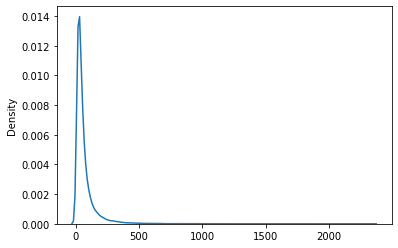

In [9]:
sns.kdeplot(nim_vis_per_pat)

# Building the Conditional Code Swapping (CCS) weighting function

In [10]:
#find the unique medical codes
list_toks = []
for pat in tqdm(vis_seq_df_str):
    vis_traj = pat.split(".")
    for vis in vis_traj:
        list_toks.extend(vis.split(" "))
uniq_toks = list(np.unique(list_toks))
len(uniq_toks)

100%|█████████████████████████████████| 52832/52832 [00:00<00:00, 257700.98it/s]


4688

In [14]:
#build an empty 2d numpy matrix
transit_mat = np.zeros((len(uniq_toks), len(uniq_toks)),int)

def fill_transit_mat(pat_traj_list, from_pat, to_pat):
    transit_mat_temp = np.zeros((len(uniq_toks), len(uniq_toks)),int)
    for pat in tqdm(pat_traj_list[from_pat:to_pat]):
        vis_traj = pat.split(".")
        for vis_ind1 in range(len(vis_traj)-1):
            for code1 in vis_traj[vis_ind1].split(" "):
                for vis_ind2 in range(vis_ind1+1, len(vis_traj)):
                    for code2 in vis_traj[vis_ind2].split(" "):
                        transit_mat_temp[uniq_toks.index(code1), uniq_toks.index(code2)]+=1
    return transit_mat_temp

In [ ]:
#use multiprocessing fro calculating the CCS 
import multiprocessing
import time


num_pats = len(vis_seq_df_str)
num_cpus =18 
    
if __name__ == "__main__":
    pool = multiprocessing.Pool(num_cpus)
    start_time = time.perf_counter()
    processes = [pool.apply_async(fill_transit_mat, args=(vis_seq_df_str, x, x+700, )) for x in range(0,num_pats,700)]
    result = [p.get() for p in processes]
    finish_time = time.perf_counter()
    print(f"Program finished in {finish_time-start_time} seconds")
    #print(result)

  7%|███                                       | 52/700 [00:58<28:59,  2.68s/it]

In [ ]:
transit_mat = np.zeros((len(uniq_toks), len(uniq_toks)),int)
for res in result:
    transit_mat +=res

In [ ]:
#save transmat_mat on disk

with open('/nfs/home/aliami/causalg2.npy', 'wb') as f:
    np.save(f, transit_mat)

In [11]:
#load the transit_mat

with open('/nfs/home/aliami/mimic4_dataset/physionet.org/files/mimiciv/2.2/hosp/pre_proc_data/causalg.npy', 'rb') as f:
    transit_mat = np.load(f)

In [12]:
# make the CCS to uni-directional transition matrix by max(0, a(i,j)-a(j,i))
transit_mat_one_dir = transit_mat.copy()
for i in tqdm(range(transit_mat_one_dir.shape[0])):
    for j in range(transit_mat_one_dir.shape[1]):
        transit_mat_one_dir[i,j] = max(0, transit_mat_one_dir[i,j]-transit_mat_one_dir[j,i])

100%|██████████████████████████████████████| 4688/4688 [00:14<00:00, 319.77it/s]


In [13]:
#Smooth the CCS by summing the ccs score for codes with the first 3 digits in common 
dict_inds_sim = {}
dig_granular = 3

for ind_tok, uni_tok in enumerate(uniq_toks):
    granulae_tok = uni_tok[:dig_granular+2]
    if granulae_tok in dict_inds_sim.keys():
        dict_inds_sim[granulae_tok].append(ind_tok)
    else:
        dict_inds_sim[granulae_tok] = [ind_tok]
    
#add rows and columnith similar first digits
transit_mat_light = transit_mat_one_dir.copy()
#first sum up similar rows
for key, val in dict_inds_sim.items():
    temp_row = np.zeros((1,len(uniq_toks)), dtype=int)
    for row in val:
        temp_row += transit_mat_one_dir[row,:]
    for row in val:
        transit_mat_light[row, :] = temp_row.copy()
        
        
#then sum up similar columns
for key, val in dict_inds_sim.items():
    temp_col = np.zeros((1,transit_mat_light.shape[0]), dtype=int)
    for col in val:
        temp_col += transit_mat_one_dir[:,col]
    for col in val:
        transit_mat_light[:,col] = temp_col.copy()
    

        
    


In [14]:
#Scaling by deviding by ratio between medication and diagnoses

count_diag = 0
count_med = 0
for tok,val in dict_inds_sim.items():
    if "d_" in tok:
        count_diag+=1
    else:
        count_med+=1
print(count_diag, count_med) 

transit_mat_light = transit_mat_light.astype('float64')

scale_factor = .5*count_diag/count_med
for ind,tok in enumerate(uniq_toks):
    if "d_" in tok:
        transit_mat_light[ind,:] *= scale_factor

for ind,tok in enumerate(uniq_toks):
    if "d_" in tok:
        transit_mat_light[:,ind] *= scale_factor
        

953 77


Prepare data for the following task by assigning to "main_task" arguments:

    #Mask Language Model: "MLM"; 
    #Conditional Code Swapping  (CCS): "gcausal_swap_token";
    #Conditional Visit Swapping (CVS):"gcaus_swap_visit";
    #Random Code Swap (RCS):"random_swap_token";
    #Random Visit Swap (RVS): "random_swap_visit"

# Build TOO-Bert dataset

In [28]:

class BertDatasetBuilder(Dataset):
    CLS = '[CLS]'
    PAD = '[PAD]'
    SEP = '[sep]'
    MASK = '[MASK]'
    UNK = '[UNK]'
    END = '[end]'

    MASK_PERCENTAGE = 0.15

    MASKED_INDICES_COLUMN = 'masked_indices'
    TARGET_COLUMN = 'indices'
    NSP_TARGET_COLUMN = 'is_next'
    TOKEN_MASK_COLUMN = 'token_mask'

    OPTIMAL_LENGTH_PERCENTILE = 70

    def __init__(self, path, input_data,  ds_from=None, ds_to=None, should_include_text=False,
                 vocabulary= None, optimal_token_len_per_row=None, single_modal_mask=False, equal_masking=False,
                swap_med_diag=False, auxiliary_task=False, main_task="MLM"):
        
        #valid options for main_task:         
        # mlm: "MLM"; 
        #Conditional Code Swapping  (CCS): "gcausal_swap_token";
        #Conditional Visit Swapping (CVS):"gcaus_swap_visit";
        #Random Code Swap (RCS):"random_swap_token";
        #Random Visit Swap (RVS): "random_swap_visit"
        
        
        self.ds: pd.Series = input_data#vis_seq_df_str#pd.read_csv(path)['review']

        if ds_from is not None or ds_to is not None:
            self.ds = self.ds[ds_from:ds_to]

        self.tokenizer = get_tokenizer('basic_english')
        self.counter = Counter()
        self.vocab = vocabulary

        self.optimal_sentence_length = None
        self.optimal_token_len_per_row = optimal_token_len_per_row
        self.should_include_text = should_include_text
        self.equal_masking = equal_masking
        self.swap_med_diag = swap_med_diag
        
        self.auxiliary_task = auxiliary_task
        self.main_task = main_task
        
        #setting for only masking one modality
        #options: False, only_diags, only_meds
        self.single_modal_mask = single_modal_mask
        #if self.single_modal_mask:
            #self.MASK_PERCENTAGE = self.cal_mask_percentage(self.single_modal_mask)
            #print("for "+self.single_modal_mask+" MASK_PERCENTAGE is"+str(self.MASK_PERCENTAGE))

        if should_include_text:
            self.columns = ['masked_sentence', self.MASKED_INDICES_COLUMN, 'sentence', self.TARGET_COLUMN,
                            self.TOKEN_MASK_COLUMN,
                            self.NSP_TARGET_COLUMN]
        else:
            self.columns = [self.MASKED_INDICES_COLUMN, self.TARGET_COLUMN, self.TOKEN_MASK_COLUMN,
                            self.NSP_TARGET_COLUMN]

        if self.main_task=="MLM":
            self.df = self.prepare_dataset()
            
        if self.main_task=="lift_based_swap":
            self.complete_df = pd.read_csv("complete_df_asso_rule.csv", index_col=0)["Lift"]
            self.df = self.prepare_dataset_swap()
            
        if self.main_task=="gcausal_swap_token" or self.main_task=="gcaus_swap_visit":
            self.uniq_toks = [uni_code.lower() for uni_code in uniq_toks]
            self.items_as_dict = dict(zip(self.uniq_toks,range(0,len(self.uniq_toks))))
            self.row_count = 0
            self.df = self.prepare_dataset_swap()
        if self.main_task=="random_swap_visit" or self.main_task=="random_swap_token":
            #self.uniq_toks = [uni_code.lower() for uni_code in uniq_toks]
            #self.items_as_dict = dict(zip(self.uniq_toks,range(0,len(self.uniq_toks))))
            #self.row_count = 0
            self.df = self.prepare_dataset_swap()
        
        elif self.main_task=="swap":
            self.df = self.prepare_dataset_swap()

    def __len__(self):
        return len(self.df)
    
    def cal_mask_percentage(self, single_modal_mask):
        num_diags, num_meds = 0, 0
        for pat in self.ds:
            num_diags += len(re.findall("d_", pat))
            num_meds +=  len(re.findall("m_", pat))
        perc_mask_med = (.15*num_meds)/(num_diags+ num_meds)
        perc_mask_diag = (.15*num_diags)/(num_diags+ num_meds)
        if single_modal_mask=="only_diags":
            return perc_mask_diag
        if single_modal_mask=="only_meds":
            return perc_mask_med

    def __getitem__(self, idx):
        item = self.df.iloc[idx]

        inp = torch.Tensor(item[self.MASKED_INDICES_COLUMN]).long()
        token_mask = torch.Tensor(item[self.TOKEN_MASK_COLUMN]).bool()

        mask_target = torch.Tensor(item[self.TARGET_COLUMN]).long()
        mask_target = mask_target.masked_fill_(token_mask, 0)

        attention_mask = (inp == self.vocab[self.PAD]).unsqueeze(0)

        if item[self.NSP_TARGET_COLUMN] == 0:
            t = [1, 0]
        else:
            t = [0, 1]

        nsp_target = torch.Tensor(t)

        return (
            inp.to(device),
            attention_mask.to(device),
            token_mask.to(device),
            mask_target.to(device),
            nsp_target.to(device)
        )
    
    def prepare_dataset_swap(self) -> pd.DataFrame:
        sentences = []
        nsp = []
        sentence_lens = []
        num_codes_per_pat = []

        # Split dataset on sentences
        for review in self.ds:
            num_codes_per_pat.append(len(review.split(" ")))
            review_sentences = review.split('.')
            sentences += review_sentences
            self._update_length(review_sentences, sentence_lens)
        if self.optimal_token_len_per_row == None:
            self.optimal_token_len_per_row = int(np.percentile(num_codes_per_pat, 
                                                               self.OPTIMAL_LENGTH_PERCENTILE))
            print("optimal_token_len_per_row = ", self.optimal_token_len_per_row)
        self.optimal_sentence_length = self._find_optimal_sentence_length(sentence_lens)

        print("Create vocabulary")
        #ALI: I changed sentences to vis_seq_df_str to build a dictionary with all possible words
        for sentence in tqdm(vis_seq_df_str):
            s = self.tokenizer(sentence)
            self.counter.update(s)

        self._fill_vocab()
        
        
        #for having fix size rows based on number of tokens
        print("Preprocessing dataset")
        for pat_hist in tqdm(self.ds):
            pat_hist_toks = pat_hist.replace('.', self.SEP).split(" ")
            #pat_hist_toks += [self.END]
            history_len = len(pat_hist_toks)
            window_jump = 1
            for i in range(0, history_len, window_jump):
                
                segm = self.tokenizer(' '.join(pat_hist_toks[i :i+self.optimal_token_len_per_row]))
                if segm[0]==self.SEP: continue #should not start with sep
                #if segm[-1] != self.SEP: segm.append(self.SEP) #add sep at the end of artifacial trajectories
                nsp.append(self._create_item(segm, 1, should_masked=False))
                
                if self.main_task=="swap":#self.auxiliary_task == "swap":
                    #only for trajectories with more than 1 visits and more than 3 uniq tokens (sep, unk, x)
                    if segm.count(self.SEP) >1 and len(np.unique(segm))>3:
                        #segm_corrupted = self._add_swapping_noise(segm)
                        segm_corrupted = self._add_swapping_all_codes_noise(segm)
                        nsp.append(self._create_item(segm_corrupted, 0, should_masked=False))
                if self.main_task=="lift_based_swap":
                    #read the prepared association rules mining file
                    
                    #only for trajectories with more than 1 visits and more than 3 uniq tokens (sep, unk, x)
                    if segm.count(self.SEP) >1 and len(np.unique(segm))>3:
                        segm_corrupted = self._add_lift_based_swap(segm, .25)
                        nsp.append(self._create_item(segm_corrupted, 0, should_masked=False))
                #gcausal_swap
                if self.main_task=="gcausal_swap":
                    #read the prepared association rules mining file
                    
                    #only for trajectories with more than 1 visits and more than 3 uniq tokens (sep, unk, x)
                    if segm.count(self.SEP) >1 and len(np.unique(segm))>3:
                        segm_corrupted = self._add_gcausal_based_swap(segm, .5)
                        nsp.append(self._create_item(segm_corrupted, 0, should_masked=False))
                        
                if self.main_task=="gcaus_swap_visit":
                    #only for trajectories with more than 1 visits and more than 3 uniq tokens (sep, unk, x)
                    if segm.count(self.SEP) >2 and len(np.unique(segm))>3:
                        segm_corrupted = self._add_gcausal_swap_visit(segm, .5)
                        nsp.append(self._create_item(segm_corrupted, 0, should_masked=False))
                if self.main_task=="gcausal_swap_token":
                    #read the prepared association rules mining file
                    #only for trajectories with more than 1 visits and more than 3 uniq tokens (sep, unk, x)
                    if segm.count(self.SEP) >1 and len(np.unique(segm))>3:
                        segm_corrupted = self._add_gcausal_based_swap_token(segm, .45)
                        nsp.append(self._create_item(segm_corrupted, 0, should_masked=False))
                        
                if self.main_task=="random_swap_token":
                    #read the prepared association rules mining file
                    
                    #only for trajectories with more than 1 visits and more than 3 uniq tokens (sep, unk, x)
                    if segm.count(self.SEP) >1 and len(np.unique(segm))>3:
                        segm_corrupted = self._add_random_swap_token(segm, .45)
                        nsp.append(self._create_item(segm_corrupted, 0, should_masked=False))
                        
                if self.main_task=="random_swap_visit":
                    #only for trajectories with more than 1 visits and more than 3 uniq tokens (sep, unk, x)
                    if segm.count(self.SEP) >2 and len(np.unique(segm))>3:
                        segm_corrupted = self._add_random_swap_visit(segm, 1)
                        nsp.append(self._create_item(segm_corrupted, 0, should_masked=False))
                        
                    
                           
                
                if i+self.optimal_token_len_per_row >= history_len:
                    break

        df = pd.DataFrame(nsp, columns=self.columns)
        return df

    def prepare_dataset(self) -> pd.DataFrame:
        sentences = []
        nsp = []
        sentence_lens = []
        num_codes_per_pat = []

        # Split dataset on sentences
        for review in self.ds:
            num_codes_per_pat.append(len(review.split(" ")))
            review_sentences = review.split('.')
            sentences += review_sentences
            self._update_length(review_sentences, sentence_lens)
        if self.optimal_token_len_per_row == None:
            self.optimal_token_len_per_row = int(np.percentile(num_codes_per_pat, 
                                                               self.OPTIMAL_LENGTH_PERCENTILE))
            print("optimal_token_len_per_row = ", self.optimal_token_len_per_row)
        self.optimal_sentence_length = self._find_optimal_sentence_length(sentence_lens)

        print("Create vocabulary")
        #ALI: I changed sentences to vis_seq_df_str to build a dictionary with all possible words
        for sentence in tqdm(vis_seq_df_str):
            s = self.tokenizer(sentence)
            self.counter.update(s)

        self._fill_vocab()
        
        
        #for having fix size rows based on number of tokens
        print("Preprocessing dataset")
        for pat_hist in tqdm(self.ds):
            pat_hist_toks = pat_hist.replace('.', self.SEP).split(" ")
            #pat_hist_toks += [self.END]
            history_len = len(pat_hist_toks)
            window_jump = 1
            for i in range(0, history_len, window_jump):
                
                segm = self.tokenizer(' '.join(pat_hist_toks[i :i+self.optimal_token_len_per_row]))
                if segm[0]==self.SEP: continue #should not start with sep
                #if segm[-1] != self.SEP: segm.append(self.SEP) #add sep at the end of artifacial trajectories
                    
                nsp.append(self._create_item(segm, 1, should_masked=True))
                
                if self.auxiliary_task == "swap":
                    #only for trajectories with more than 1 visits
                    if segm.count(self.SEP) >1:
                        segm_corrupted = self._add_swapping_noise(segm)
                        nsp.append(self._create_item(segm_corrupted, 0, should_masked=False))
                
                if i+self.optimal_token_len_per_row >= history_len:
                    break

        df = pd.DataFrame(nsp, columns=self.columns)
        return df
        
        #for using two sentence instead of a fixed number of tokens
        print("Preprocessing dataset")
        for review in tqdm(self.ds):
            review_sentences = review.split('. ')
            if len(review_sentences) > 1:
                for i in range(len(review_sentences) - 1):
                    # True NSP item
                    first, second = self.tokenizer(review_sentences[i]), self.tokenizer(review_sentences[i + 1])
                    nsp.append(self._create_item(first, second, 1))

                    # False NSP item
                    first, second = self._select_false_nsp_sentences(sentences)
                    first, second = self.tokenizer(first), self.tokenizer(second)
                    nsp.append(self._create_item(first, second, 0))
        df = pd.DataFrame(nsp, columns=self.columns)
        return df

    def _update_length(self, sentences: typing.List[str], lengths: typing.List[int]):
        for v in sentences:
            l = len(v.split())
            lengths.append(l)
        return lengths

    def _find_optimal_sentence_length(self, lengths: typing.List[int]):
        arr = np.array(lengths)
        return int(np.percentile(arr, self.OPTIMAL_LENGTH_PERCENTILE))

    def _fill_vocab(self):
        # specials= argument is only in 0.12.0 version
        # specials=[self.CLS, self.PAD, self.MASK, self.SEP, self.UNK]
        if self.vocab == None:
            self.vocab = vocab(self.counter, min_freq=20)

            # 0.11.0 uses this approach to insert specials
            self.vocab.insert_token(self.CLS, 0)
            self.vocab.insert_token(self.PAD, 1)
            self.vocab.insert_token(self.MASK, 2)
            self.vocab.insert_token(self.SEP, 3)
            self.vocab.insert_token(self.UNK, 4)
            #self.vocab.insert_token(self.END, 5)
            self.vocab.set_default_index(4)

    def _create_item(self, first: typing.List[str], target: int = 1, should_masked=True):
        # Create masked sentence item
        second = []
        updated_first, first_mask = self._preprocess_sentence(first.copy(),should_mask=should_masked)
        updated_second, second_mask = self._preprocess_sentence(second.copy(),should_mask=should_masked)

        nsp_sentence = updated_first + [self.SEP] + updated_second
        nsp_indices = self.vocab.lookup_indices(nsp_sentence)
        inverse_token_mask = first_mask + [True] + second_mask

        # Create sentence item without masking random words
        first, _ = self._preprocess_sentence(first.copy(), should_mask=False)
        second, _ = self._preprocess_sentence(second.copy(), should_mask=False)
        original_nsp_sentence = first + [self.SEP] + second
        original_nsp_indices = self.vocab.lookup_indices(original_nsp_sentence)

        if self.should_include_text:
            return (
                nsp_sentence[:self.optimal_token_len_per_row],
                nsp_indices[:self.optimal_token_len_per_row],
                original_nsp_sentence[:self.optimal_token_len_per_row],
                original_nsp_indices[:self.optimal_token_len_per_row],
                inverse_token_mask[:self.optimal_token_len_per_row],
                target
            )
        else:
            return (
                nsp_indices[:self.optimal_token_len_per_row],
                original_nsp_indices[:self.optimal_token_len_per_row],
                inverse_token_mask[:self.optimal_token_len_per_row],
                target
            )

    def _select_false_nsp_sentences(self, sentences: typing.List[str]):
        """Select sentences to create false NSP item

        Args:
            sentences: list of all sentences

        Returns:
            tuple of two sentences. The second one NOT the next sentence
        """
        sentences_len = len(sentences)
        sentence_index = random.randint(0, sentences_len - 1)
        next_sentence_index = random.randint(0, sentences_len - 1)

        # To be sure that it's not real next sentence
        while next_sentence_index == sentence_index + 1:
            next_sentence_index = random.randint(0, sentences_len - 1)

        return sentences[sentence_index], sentences[next_sentence_index]

    def _preprocess_sentence(self, sentence: typing.List[str], should_mask: bool = True):
        inverse_token_mask = []#None
        if should_mask:
            if self.equal_masking:
                sentence, inverse_token_mask = self._mask_sentence_equally(sentence)
            elif self.swap_med_diag:
                sentence, inverse_token_mask = self._mask_swap_diag_med(sentence)
            else:
                sentence, inverse_token_mask = self._mask_sentence(sentence, self.single_modal_mask)
                
        #print(len(inverse_token_mask), inverse_token_mask)
        sentence, inverse_token_mask = self._pad_sentence([self.CLS] + sentence, [True]+inverse_token_mask)
        return sentence, inverse_token_mask
    
    def _add_random_swap_token(self, sentence: typing.List[str], swap_percent= .05):
        
        len_s = len(sentence)
        #form pairs for codes between visits:
        sep_indx = [i for i in range(len(sentence)) if sentence[i]==self.SEP]
        sep_indx.extend([-1, len_s+1])

        num_samples = max(1, int(len_s*swap_percent))
        #print("num_samples", num_samples)

        #pair_toks = []
        pair_toks_inds = []
        pair_toks_prob = []
        for tok_ind,code in enumerate(sentence):
            if tok_ind in sep_indx: continue
            #should_del_l, should_del_h = max([i for i in sep_indx if i < tok_ind]), min([i for i in sep_indx if i > tok_ind])
            should_del_h = min([i for i in sep_indx if i > tok_ind])
            should_del_l = 0
            available_tok_ind = [i for i in range(len_s) if (i<should_del_l) or (i>should_del_h)]
            #remove self.sep from available token list
            available_tok_ind = [x for x in available_tok_ind if x not in sep_indx]
            for avai_tok in available_tok_ind:
                #delete equal pairs
                if code==sentence[avai_tok]: continue
                #pair_toks.append(str(code)+str(sentence[avai_tok]))
                pair_toks_inds.append([tok_ind, avai_tok])

                #pair_toks_prob.append(transit_mat_one_dir[self.uniq_toks.index(code), self.uniq_toks.index(sentence[avai_tok])])
                #pair_toks_prob.append(transit_mat_one_dir[self.items_as_dict[code], self.items_as_dict[sentence[avai_tok]]])
                pair_toks_prob.append(1)    
                    
        #find the probability of each pair
        #build_pair_t = time.time()
        #print("build_pair_t-start_t", build_pair_t-start_t)
        
        #start_t = time.time()
        
        picked = random.choices(population=pair_toks_inds,weights=pair_toks_prob,k=num_samples)
        
        #samp_t = time.time()
        #print("samp_t-start_t", samp_t-start_t)

        #swap tokens elments in sampled list
        for samp in picked:
            sentence[samp[0]], sentence[samp[1]] = sentence[samp[1]], sentence[samp[0]]
        
        
        return sentence
    
    
    def _add_random_swap_visit(self, sentence: typing.List[str], swap_percent= .05):#it was for random swapping between two visits
        
        len_s = len(sentence)
        #form pairs for codes between visits:
        sep_indx = [i for i in range(len(sentence)) if sentence[i]==self.SEP]
        sep_indx.insert(0, 0)
        sep_indx.append(len_s+1)

        n_swap = 1#max(1, int(len_s*swap_percent))
        
        picked_list = []
        for i in range(n_swap):
            rand_sel = random.sample(sep_indx[1:-1], 2)#[0]
            if rand_sel[1] > rand_sel[0]:
                picked = [[rand_sel[0], rand_sel[1]]]
            else:
                picked = [[rand_sel[1], rand_sel[0]]]
            
            picked_list.append(picked[0])
            
        sent_str = " ".join(sentence)+" "
        sent_str_vis = sent_str.split(self.SEP)
        sent_str_vis = [x+self.SEP for x in sent_str_vis]
            
        temp = "@w*"
        for swap_num in range(n_swap):

            s1 = sep_indx.index(picked_list[swap_num][0])-1
            s2 = sep_indx.index(picked_list[swap_num][1])-1
            
            

            sent_str = sent_str.replace(sent_str_vis[s1], temp,1).replace(sent_str_vis[s2], sent_str_vis[s1],1).replace(temp, sent_str_vis[s2],1)
            #s_org.replace(s1, temp).replace(s2, s1).replace(temp, s2)
            #if there is " " at the first token                
            if sent_str[0]==" ":
                    sent_str = sent_str[1:]
                
            
        sent_str = sent_str.replace("]m","] m")
        sent_str = sent_str.replace("]d","] d")
        
        
        
        return sent_str.split(" ")[:-1]
    
    
    
    
    def _add_gcausal_swap_visit(self, sentence: typing.List[str], swap_percent= .05):
        
        len_s = len(sentence)
        #form pairs for codes between visits:
        sep_indx = [i for i in range(len(sentence)) if sentence[i]==self.SEP]
        sep_indx.insert(0, 0)
        sep_indx.append(len_s+1)

        num_samples = 2#max(1, int(len_s*swap_percent))
        #print("num_samples", num_samples)
        rand_sel = random.sample(sep_indx[1:-1], 2)#[0]
        if rand_sel[1] > rand_sel[0]:
            picked = [[rand_sel[0], rand_sel[1]]]
        else:
            picked = [[rand_sel[1], rand_sel[0]]]
            
        #sel_2 = random.sample([i for i in sep_indx if i>sel_1], 1)[0]
        #picked = [[sel_1, sel_2]]
        #picked = random.choices(population=pair_visit_ind,weights=pair_visit_prob,k=1)
        
        #print(pair_visit_ind, pair_visit_prob,picked)
        #temp_ind = pair_visit_ind.index(picked[0])
        #print(temp_ind, pair_visit_prob[temp_ind])
        #samp_t = time.time()
        #print("samp_t-start_t", samp_t-start_t)
        
        #swap the whole visits
        start_vis_s, end_vis_s = sep_indx[sep_indx.index(picked[0][0])-1] ,picked[0][0]
        #base_inds = [code_ind for code_ind in range(start_vis+1, end_vis)]
        
        start_vis_t, end_vis_t = sep_indx[sep_indx.index(picked[0][1])-1] ,picked[0][1]
        #target_inds = [code_ind for code_ind in range(start_vis+1, end_vis)]
        #print(picked)
        #print(sentence[-1])
        #print(sentence)
        #print(sentence[start_vis_s],sentence[end_vis_s],sentence[start_vis_t],sentence[end_vis_t])
        #return sentence[:start_vis_s]+sentence[start_vis_t:end_vis_t]+sentence[end_vis_s:start_vis_t]+sentence[start_vis_s:end_vis_s]+sentence[end_vis_t:]
        return sentence[:start_vis_s]+sentence[start_vis_t:end_vis_t]+sentence[end_vis_s:start_vis_t]+sentence[start_vis_s:end_vis_s]+sentence[end_vis_t:]
    
    
    
    def _add_gcausal_based_swap_token(self, sentence: typing.List[str], swap_percent= .05):
        
        len_s = len(sentence)
        #form pairs for codes between visits:
        sep_indx = [i for i in range(len(sentence)) if sentence[i]==self.SEP]
        sep_indx.extend([-1, len_s+1])

        num_samples = max(1, int(len_s*swap_percent))
        #print("num_samples", num_samples)

        #pair_toks = []
        pair_toks_inds = []
        pair_toks_prob = []
        for tok_ind,code in enumerate(sentence):
            if tok_ind in sep_indx: continue
            #should_del_l, should_del_h = max([i for i in sep_indx if i < tok_ind]), min([i for i in sep_indx if i > tok_ind])
            should_del_h = min([i for i in sep_indx if i > tok_ind])
            should_del_l = 1
            available_tok_ind = [i for i in range(len_s) if (i<should_del_l) or (i>should_del_h)]
            #remove self.sep from available token list
            available_tok_ind = [x for x in available_tok_ind if x not in sep_indx]
            for avai_tok in available_tok_ind:
                #delete equal pairs
                if code==sentence[avai_tok]: continue
                #pair_toks.append(str(code)+str(sentence[avai_tok]))
                pair_toks_inds.append([tok_ind, avai_tok])

                #pair_toks_prob.append(transit_mat_one_dir[self.uniq_toks.index(code), self.uniq_toks.index(sentence[avai_tok])])
                pair_toks_prob.append(transit_mat_one_dir[self.items_as_dict[code], self.items_as_dict[sentence[avai_tok]]])

        #find the probability of each pair
        #build_pair_t = time.time()
        #print("build_pair_t-start_t", build_pair_t-start_t)
        
        #start_t = time.time()
        

        
        #picked = random.choices(population=pair_toks_inds,weights=pair_toks_prob,k=num_samples)
        #add one to avoid zero chance
        pair_toks_prob = np.asarray(pair_toks_prob).astype('float64')+1
        pair_toks_prob = pair_toks_prob / np.sum(pair_toks_prob)
        picked = np.random.choice(len(pair_toks_inds), size=num_samples, replace=False, p=pair_toks_prob)
        picked = np.array(pair_toks_inds)[picked]
        
        
        
        
        
        
        #samp_t = time.time()
        #print("samp_t-start_t", samp_t-start_t)
        #print(picked)

        #swap tokens elments in sampled list
        for samp in picked:
            sentence[samp[0]], sentence[samp[1]] = sentence[samp[1]], sentence[samp[0]]
        
        
        return sentence
    
    
    
    
    
    def _add_gcausal_swap_visit2(self, sentence: typing.List[str], swap_percent= .05):
        
        len_s = len(sentence)
        #form pairs for codes between visits:
        sep_indx = [i for i in range(len(sentence)) if sentence[i]==self.SEP]
        sep_indx.insert(0, 0)
        sep_indx.append(len_s+1)

        num_samples = max(1, int(len_s*swap_percent))
        #print("num_samples", num_samples)

        #pair_toks = []
        pair_toks_inds = []
        pair_toks_prob = []
        pair_visit_ind = []#[[sep_indx[0], sep_indx[1]]]
        pair_visit_prob = []
        between_vis_sum_prob = 0
        for tok_ind,code in enumerate(sentence):
            if tok_ind in sep_indx: continue
            #should_del_l, should_del_h = max([i for i in sep_indx if i < tok_ind]), min([i for i in sep_indx if i > tok_ind])
            should_del_h = min([i for i in sep_indx if i > tok_ind])
            should_del_l = 0
            available_tok_ind = [i for i in range(len_s) if (i<should_del_l) or (i>should_del_h)]
            #remove self.sep from available token list
            #available_tok_ind = [x for x in available_tok_ind if x not in sep_indx]
            for avai_tok in available_tok_ind:
                if avai_tok in sep_indx:
                    if [should_del_h, avai_tok] not in pair_visit_ind:
                        pair_visit_ind.append([should_del_h, avai_tok])
                        pair_visit_prob.append(between_vis_sum_prob)
                        between_vis_sum_prob = 0
                    continue

                #delete equal pairs
                if code==sentence[avai_tok]: continue
                pair_toks_inds.append([tok_ind, avai_tok])

                #pair_toks_prob.append(transit_mat_light[self.items_as_dict[code], self.items_as_dict[sentence[avai_tok]]])
                between_vis_sum_prob += transit_mat_light[self.items_as_dict[code], self.items_as_dict[sentence[avai_tok]]]

        #find the probability of each pair
        #build_pair_t = time.time()
        #print("build_pair_t-start_t", build_pair_t-start_t)
        
        #start_t = time.time()
        
        #picked = random.choices(population=pair_toks_inds,weights=pair_toks_prob,k=num_samples)
        picked = random.choices(population=pair_visit_ind,weights=pair_visit_prob,k=1)
        
        #print(pair_visit_ind, pair_visit_prob,picked)
        #temp_ind = pair_visit_ind.index(picked[0])
        #print(temp_ind, pair_visit_prob[temp_ind])
        #samp_t = time.time()
        #print("samp_t-start_t", samp_t-start_t)
        
        #swap the whole visits
        start_vis_s, end_vis_s = sep_indx[sep_indx.index(picked[0][0])-1],picked[0][0]
        #base_inds = [code_ind for code_ind in range(start_vis+1, end_vis)]
        
        start_vis_t, end_vis_t = sep_indx[sep_indx.index(picked[0][1])-1],picked[0][1]
        #target_inds = [code_ind for code_ind in range(start_vis+1, end_vis)]
        #print(picked)
        #print(sentence)
        #print(sentence[start_vis_s],sentence[end_vis_s],sentence[start_vis_t],sentence[end_vis_t])
        return sentence[:start_vis_s]+sentence[start_vis_t:end_vis_t]+sentence[end_vis_s:start_vis_t]+sentence[start_vis_s:end_vis_s]+sentence[end_vis_t:]
        

    
    
    def _add_gcausal_based_swap(self, sentence: typing.List[str], swap_percent= .05):
        
        len_s = len(sentence)
        #form pairs for codes between visits:
        sep_indx = [i for i in range(len(sentence)) if sentence[i]==self.SEP]
        sep_indx.extend([-1, len_s+1])

        num_samples = max(1, int(len_s*swap_percent))
        #print("num_samples", num_samples)

        #pair_toks = []
        pair_toks_inds = []
        pair_toks_prob = []
        for tok_ind,code in enumerate(sentence):
            if tok_ind in sep_indx: continue
            #should_del_l, should_del_h = max([i for i in sep_indx if i < tok_ind]), min([i for i in sep_indx if i > tok_ind])
            should_del_h = min([i for i in sep_indx if i > tok_ind])
            should_del_l = 0
            available_tok_ind = [i for i in range(len_s) if (i<should_del_l) or (i>should_del_h)]
            #remove self.sep from available token list
            available_tok_ind = [x for x in available_tok_ind if x not in sep_indx]
            for avai_tok in available_tok_ind:
                #delete equal pairs
                if code==sentence[avai_tok]: continue
                #pair_toks.append(str(code)+str(sentence[avai_tok]))
                pair_toks_inds.append([tok_ind, avai_tok])

                #pair_toks_prob.append(transit_mat_one_dir[self.uniq_toks.index(code), self.uniq_toks.index(sentence[avai_tok])])
                pair_toks_prob.append(transit_mat_one_dir[self.items_as_dict[code], self.items_as_dict[sentence[avai_tok]]])

        #find the probability of each pair
        #build_pair_t = time.time()
        #print("build_pair_t-start_t", build_pair_t-start_t)
        
        #start_t = time.time()
        
        picked = random.choices(population=pair_toks_inds,weights=pair_toks_prob,k=num_samples)
        
        #samp_t = time.time()
        #print("samp_t-start_t", samp_t-start_t)

        #swap tokens elments in sampled list
        for samp in picked:
            sentence[samp[0]], sentence[samp[1]] = sentence[samp[1]], sentence[samp[0]]
        
        
        return sentence
    
    
    def _add_lift_based_swap(self, sentence: typing.List[str], swap_percent= .05):

        len_s = len(sentence)
        #form pairs for codes between visits:
        sep_indx = [i for i in range(len(sentence)) if sentence[i]==self.SEP]
        sep_indx.extend([-1, len_s+1])

        num_samples = max(1, int(len_s*swap_percent))
        #print("num_samples", num_samples)

        pair_toks = []
        pair_toks_inds = []
        for tok_ind,code in enumerate(sentence):
            if tok_ind in sep_indx: continue
            should_del_l, should_del_h = max([i for i in sep_indx if i < tok_ind]), min([i for i in sep_indx if i > tok_ind])
            available_tok_ind = [i for i in range(len_s) if (i<should_del_l) or (i>should_del_h)]
            #remove self.sep from available token list
            available_tok_ind = [x for x in available_tok_ind if x not in sep_indx]
            for avai_tok in available_tok_ind:
                #delete equal pairs
                if code==sentence[avai_tok]: continue
                pair_toks.append(str(code)+str(sentence[avai_tok]))
                pair_toks_inds.append([tok_ind, avai_tok])

        #find the probability of each pair
        
        probs_list =  self.complete_df.loc[pair_toks].reset_index()["Lift"]
        

        picked = random.choices(population=pair_toks_inds,weights=probs_list,k=num_samples)

        #swap tokens elments in sampled list
        for samp in picked:
            sentence[samp[0]], sentence[samp[1]] = sentence[samp[1]], sentence[samp[0]]
        
        
        return sentence

    def _add_swapping_all_codes_noise(self, sentence: typing.List[str]):
        #instead of swapping only one code, we swapp all the mdeications with all diagnoses on the other visits and so on
        
        single_source_inp = False
        #check if there were tokens only from one modality
        if ("m_" in "".join(sentence)) != ("d_" in "".join(sentence)):
            single_source_inp == True
        unusful_vocabs = [self.SEP, self.UNK, self.CLS]
        base_ind = 0
        #base_token = unusful_vocabs[0]
        len_s = len(sentence)
        
        med_toks_ind = [i for i in range(len(sentence)) if re.match("m_", sentence[i])]
        diag_toks_ind = [i for i in range(len(sentence)) if re.match("d_", sentence[i])]
        
        #reomove all words within the sentence of the base_token to force the swap between sentences 
        sep_indx = [i for i in range(len(sentence)) if sentence[i]==self.SEP]
        #add -1, len(s)+1 to sep_indx for base_ind in first or the last visit
        sep_indx.extend([-1, len_s+1])
            
        
        def random_swapping_between_visits(base_ind=False):
            #print("Random masking")
            if not(base_ind):
                while sentence[base_ind] in unusful_vocabs: base_ind=random.sample(range(len_s), k=1)[0];
            #print("random swap")
            #should_del_l, should_del_h = max([i for i in range(sep_indx) if i >= base_ind]), min([i for i in range(sep_indx) if i >= base_ind])
            should_del_l, should_del_h = max([i for i in sep_indx if i < base_ind]), min([i for i in sep_indx if i > base_ind])
            available_tok_ind = [i for i in range(len_s) if (i<should_del_l) or (i>should_del_h)]
            ##
            #for deleting all meds and visits
            base_ind_all = [i for i in range(len_s) if (i>should_del_l) and (i<should_del_h)]
            #base_ind_all = list(range(should_del_l+1,should_del_h-1))
            return swap_ind_selector(base_ind,available_tok_ind,base_ind_all)
            ##
            swap_ind = base_ind
            while sentence[swap_ind] == sentence[base_ind]: swap_ind = random.sample(available_tok_ind, k=1)[0];available_tok_ind.remove(swap_ind)
            sentence[base_ind], sentence[swap_ind] = sentence[swap_ind], sentence[base_ind]
            return sentence
        
        def swap_ind_selector(base_ind,available_tokens_list,selected_base_inds):
            swap_ind = base_ind
            available_tokens_list_copy = available_tokens_list.copy()
            while sentence[swap_ind] == sentence[base_ind]:
                if len(available_tokens_list)==0:
                    return random_swapping_between_visits(base_ind)
                swap_ind = random.sample(available_tokens_list, k=1)[0]
                available_tokens_list.remove(swap_ind)

            
            #select all the codes in the selected visits which has the same type with the swap_ind codes
            should_del_l, should_del_h = max([i for i in sep_indx if i < swap_ind]), min([i for i in sep_indx if i > swap_ind])
            all_swap_tok_inds = [i for i in available_tokens_list_copy if (i>should_del_l) and (i<should_del_h)]

            visit_num_base = max([i for i in sep_indx if i < min(selected_base_inds)])
            visist_num_swap = max([i for i in sep_indx if i < min(all_swap_tok_inds)])
            #remove base_inds from the original sentencse
            sentence_base_toks = [sentence[i] for i in selected_base_inds]
            sentence_swap_toks = [sentence[i] for i in all_swap_tok_inds]
            
            #remove sentence_swap_inds from the original sentence
            sentence_without_swap_inds = [sentence[i] for i in range(len_s) if sentence[i] not in sentence_swap_toks]
            sentence_without_base_inds = [sentence[i] for i in range(len_s) if sentence[i] not in sentence_base_toks]
            
            if visit_num_base < visist_num_swap:
                #swapped_sent = sentence[:visit_num_base]+sentence_swap_toks+sentence_without_base_inds[visit_num_base:visist_num_swap]
                middle_toks_without_base = [sentence[i] for i in range(visit_num_base+1,visist_num_swap) if  i not in selected_base_inds]
                last_toks_without_swap = [sentence[i] for i in range(visist_num_swap,len_s) if i not in all_swap_tok_inds]
                fin_swapped = sentence[:visit_num_base+1]+sentence_swap_toks+middle_toks_without_base+sentence_base_toks+last_toks_without_swap
                #print(len(sentence), sentence)
                #print("selected_base_inds", selected_base_inds, sentence_base_toks)
                #print("all_swap_tok_inds", all_swap_tok_inds, sentence_swap_toks)
                #print("visit_num_base", visit_num_base)
                #print("final_swapped = ", fin_swapped)
                return del_duplic_in_visits(fin_swapped)    
            else:
                middle_toks_without_swap = [sentence[i] for i in range(visist_num_swap+1,visit_num_base) if  i not in all_swap_tok_inds]
                last_toks_without_base = [sentence[i] for i in range(visit_num_base,len_s) if i not in selected_base_inds]
                fin_swapped = sentence[:visist_num_swap+1]+sentence_base_toks+middle_toks_without_swap+sentence_swap_toks+last_toks_without_base
                return del_duplic_in_visits(fin_swapped)
            
        def del_duplic_in_visits(swapped_sent):

            whole_traj = []
            visit_codes = []
            for i in range(len(swapped_sent)):
                visit_codes.append(swapped_sent[i])
                if swapped_sent[i]=='[sep]' or i==len(swapped_sent)-1:
                    whole_traj.extend(list(OrderedDict.fromkeys(visit_codes)))
                    visit_codes.clear()
            return whole_traj
                    
                
            
            
        
        
            #decide 33% swap: med<->diag,or med<->med,or diag<->diag
        if not(single_source_inp):
                triple_decide = random.random()
                #med<->diag
                if triple_decide < 0.33:
                    #print("med<->diag")
                    if len(med_toks_ind)==0:
                        return random_swapping_between_visits()
                    base_ind=random.sample(med_toks_ind, k=1)[0];
                    #should_del_l, should_del_h = max([i for i in range(len_s) if i >= base_ind]), min([i for i in range(len_s) if i >= base_ind])
                    should_del_l, should_del_h = max([i for i in sep_indx if i < base_ind]), min([i for i in sep_indx if i > base_ind])
                    base_ind_all_meds = [i for i in med_toks_ind if (i>should_del_l) and (i<should_del_h)]
                    available_tok_ind = [i for i in range(len_s) if (i<should_del_l) or (i>should_del_h)]
                    diag_toks_ind = [i for i in available_tok_ind if re.match("d_", sentence[i])]
                    
                    if len(diag_toks_ind)==0:
                        return random_swapping_between_visits(base_ind)
                    else:
                        #print("med<->diag")
                        return swap_ind_selector(base_ind,diag_toks_ind,base_ind_all_meds)
                       
                #med<->med
                elif triple_decide < 0.66:
                    #print("med<->med")
                    #base_ind = random.sample(med_toks_ind, k=1)[0]
                    if len(med_toks_ind)==0:
                        return random_swapping_between_visits()
                    base_ind=random.sample(med_toks_ind, k=1)[0];
                    #should_del_l, should_del_h = max([i for i in range(len_s) if i >= base_ind]), min([i for i in range(len_s) if i >= base_ind])
                    should_del_l, should_del_h = max([i for i in sep_indx if i < base_ind]), min([i for i in sep_indx if i > base_ind])
                    base_ind_all_meds = [i for i in med_toks_ind if (i>should_del_l) and (i<should_del_h)]
                    available_tok_ind = [i for i in range(len_s) if (i<should_del_l) or (i>should_del_h)]
                    med_toks_ind = [i for i in available_tok_ind if re.match("m_", sentence[i])]
                    if len(med_toks_ind)==0:
                        return random_swapping_between_visits(base_ind)
                    else:
                        #print("med<->med")
                        return swap_ind_selector(base_ind,med_toks_ind,base_ind_all_meds)
                        #return swap_ind_selector(base_ind,med_toks_ind)
                        
                #diag<->diag
                else:
                    #print("diag<->diag")
                    #base_ind = random.sample(diag_toks_ind, k=1)[0]
                    if len(diag_toks_ind)==0:
                        return random_swapping_between_visits()
                    base_ind=random.sample(diag_toks_ind, k=1)[0];
                    #should_del_l, should_del_h = max([i for i in range(len_s) if i >= base_ind]), min([i for i in range(len_s) if i >= base_ind])
                    should_del_l, should_del_h = max([i for i in sep_indx if i < base_ind]), min([i for i in sep_indx if i > base_ind])
                    base_ind_all_diags = [i for i in diag_toks_ind if (i>should_del_l) and (i<should_del_h)]
                    available_tok_ind = [i for i in range(len_s) if (i<should_del_l) or (i>should_del_h)]
                    diag_toks_ind = [i for i in available_tok_ind if re.match("d_", sentence[i])]
                    if len(diag_toks_ind)==0:
                        return random_swapping_between_visits(base_ind)
                    else:
                        #print("diag<->diag")
                        return swap_ind_selector(base_ind,diag_toks_ind,base_ind_all_diags)
                        #return swap_ind_selector(base_ind,diag_toks_ind)
                        #swap_ind = random.sample(diag_toks_ind, k=1)[0]
                        #swap_ind = base_ind
                        #while sentence[swap_ind] == sentence[base_ind]: swap_ind = random.sample(diag_toks_ind, k=1)[0];diag_toks_ind.remove(swap_ind)
                        #sentence[base_ind], sentence[swap_ind] = sentence[swap_ind], sentence[base_ind]
        else:
            #print("single modal")
            random_swapping_between_visits()
            
            
        return sentence
    
    
    def _add_swapping_noise(self, sentence: typing.List[str]):
        single_source_inp = False
        #check if there were tokens only from one modality
        if ("m_" in "".join(sentence)) != ("d_" in "".join(sentence)):
            single_source_inp == True
        unusful_vocabs = [self.SEP, self.UNK, self.CLS]
        base_ind = 0
        #base_token = unusful_vocabs[0]
        len_s = len(sentence)
        
        med_toks_ind = [i for i in range(len(sentence)) if re.match("m_", sentence[i])]
        diag_toks_ind = [i for i in range(len(sentence)) if re.match("d_", sentence[i])]
        
        #reomove all words within the sentence of the base_token to force the swap between sentences 
        sep_indx = [i for i in range(len(sentence)) if sentence[i]==self.SEP]
        #add -1, len(s)+1 to sep_indx for base_ind in first or the last visit
        sep_indx.extend([-1, len_s+1])
            
        
        def random_swapping_between_visits(base_ind=False):
            #print("Random masking")
            if not(base_ind):
                while sentence[base_ind] in unusful_vocabs: base_ind=random.sample(range(len_s), k=1)[0];
            #print("random swap")
            #should_del_l, should_del_h = max([i for i in range(sep_indx) if i >= base_ind]), min([i for i in range(sep_indx) if i >= base_ind])
            should_del_l, should_del_h = max([i for i in sep_indx if i < base_ind]), min([i for i in sep_indx if i > base_ind])
            available_tok_ind = [i for i in range(len_s) if (i<should_del_l) or (i>should_del_h)]
            #swap_ind = random.sample(available_tok_ind, k=1)[0]
            swap_ind = base_ind
            while sentence[swap_ind] == sentence[base_ind]: swap_ind = random.sample(available_tok_ind, k=1)[0];available_tok_ind.remove(swap_ind)
            sentence[base_ind], sentence[swap_ind] = sentence[swap_ind], sentence[base_ind]
            return sentence
        
        def swap_ind_selector(base_ind,available_tokens_list):
            swap_ind = base_ind
            while sentence[swap_ind] == sentence[base_ind]:
                if len(available_tokens_list)==0:
                    return random_swapping_between_visits(base_ind)
                swap_ind = random.sample(available_tokens_list, k=1)[0]
                available_tokens_list.remove(swap_ind)
                
            sentence[base_ind], sentence[swap_ind] = sentence[swap_ind], sentence[base_ind]
            return sentence
        
        
            #decide 33% swap: med<->diag,or med<->med,or diag<->diag
        if not(single_source_inp):
                triple_decide = random.random()
                #med<->diag
                if triple_decide < 0.33:
                    #print("med<->diag")
                    #base_ind = random.sample(med_toks_ind, k=1)[0]
                    if len(med_toks_ind)==0:
                        return random_swapping_between_visits()
                    base_ind=random.sample(med_toks_ind, k=1)[0];
                    #should_del_l, should_del_h = max([i for i in range(len_s) if i >= base_ind]), min([i for i in range(len_s) if i >= base_ind])
                    should_del_l, should_del_h = max([i for i in sep_indx if i < base_ind]), min([i for i in sep_indx if i > base_ind])
                    available_tok_ind = [i for i in range(len_s) if (i<should_del_l) or (i>should_del_h)]
                    diag_toks_ind = [i for i in available_tok_ind if re.match("d_", sentence[i])]
                    if len(diag_toks_ind)==0:
                        return random_swapping_between_visits(base_ind)
                    else:
                        #print("med<->diag")
                        return swap_ind_selector(base_ind,diag_toks_ind)
                        #swap_ind = random.sample(diag_toks_ind, k=1)[0]
                        #swap_ind = base_ind
                        #while sentence[swap_ind] == sentence[base_ind]: swap_ind = random.sample(diag_toks_ind, k=1)[0];diag_toks_ind.remove(swap_ind)
                        #sentence[base_ind], sentence[swap_ind] = sentence[swap_ind], sentence[base_ind]
                #med<->med
                elif triple_decide < 0.66:
                    #print("med<->med")
                    #base_ind = random.sample(med_toks_ind, k=1)[0]
                    if len(med_toks_ind)==0:
                        return random_swapping_between_visits()
                    base_ind=random.sample(med_toks_ind, k=1)[0];
                    #should_del_l, should_del_h = max([i for i in range(len_s) if i >= base_ind]), min([i for i in range(len_s) if i >= base_ind])
                    should_del_l, should_del_h = max([i for i in sep_indx if i < base_ind]), min([i for i in sep_indx if i > base_ind])
                    available_tok_ind = [i for i in range(len_s) if (i<should_del_l) or (i>should_del_h)]
                    med_toks_ind = [i for i in available_tok_ind if re.match("m_", sentence[i])]
                    if len(med_toks_ind)==0:
                        return random_swapping_between_visits(base_ind)
                    else:
                        #print("med<->med")
                        return swap_ind_selector(base_ind,med_toks_ind)
                        #swap_ind = random.sample(med_toks_ind, k=1)[0]
                        #swap_ind = base_ind
                        #while sentence[swap_ind] == sentence[base_ind]: swap_ind = random.sample(med_toks_ind, k=1)[0];med_toks_ind.remove(swap_ind)
                        #sentence[base_ind], sentence[swap_ind] = sentence[swap_ind], sentence[base_ind]
                #diag<->diag
                else:
                    #print("diag<->diag")
                    #base_ind = random.sample(diag_toks_ind, k=1)[0]
                    if len(diag_toks_ind)==0:
                        return random_swapping_between_visits()
                    base_ind=random.sample(diag_toks_ind, k=1)[0];
                    #should_del_l, should_del_h = max([i for i in range(len_s) if i >= base_ind]), min([i for i in range(len_s) if i >= base_ind])
                    should_del_l, should_del_h = max([i for i in sep_indx if i < base_ind]), min([i for i in sep_indx if i > base_ind])
                    available_tok_ind = [i for i in range(len_s) if (i<should_del_l) or (i>should_del_h)]
                    diag_toks_ind = [i for i in available_tok_ind if re.match("d_", sentence[i])]
                    if len(diag_toks_ind)==0:
                        return random_swapping_between_visits(base_ind)
                    else:
                        #print("diag<->diag")
                        return swap_ind_selector(base_ind,diag_toks_ind)
                        #swap_ind = random.sample(diag_toks_ind, k=1)[0]
                        #swap_ind = base_ind
                        #while sentence[swap_ind] == sentence[base_ind]: swap_ind = random.sample(diag_toks_ind, k=1)[0];diag_toks_ind.remove(swap_ind)
                        #sentence[base_ind], sentence[swap_ind] = sentence[swap_ind], sentence[base_ind]
        else:
            #print("single modal")
            random_swapping_between_visits()
            
            
        return sentence
            
        
                    
                    
        
        while base_token in unusful_vocabs: base_ind=random.randint(0, len_s - 1); base_token = sentence[base_ind]
            
        #reomove all words within the sentence of the base_token to force the swap between sentences 
        sep_indx = [i for i in range(len(sentence)) if sentence[i]==self.SEP]
        should_del_l, should_del_h = max([i for i in a if i >= base_ind]), min([i for i in a if i >= base_ind])
        available_tok_ind = [i for i in range(len_s) if (i<should_del_l) or (i>should_del_h)]
    
        med_toks_ind = [i for i in available_tok_ind if re.match("m_", sentence[i])]
        diag_toks_ind = [i for i in available_tok_ind if re.match("d_", sentence[i])]
        
        #if len(med_toks_ind)
        
        #print(base_ind, base_token, sentence)
        #print(zzz)
            

    def _mask_sentence(self, sentence: typing.List[str], single_modal_mask=False, remain_amount_mask=False):
        #print("sentence = ", sentence)
        """Replace MASK_PERCENTAGE (15%) of words with special [MASK] symbol
        or with random word from vocabulary

        Args:
            sentence: sentence to process

        Returns:
            tuple of processed sentence and inverse token mask
        """
        unusful_vocabs = [self.SEP, self.UNK, self.CLS]
        
        len_s = len(sentence)
        inverse_token_mask = [True for _ in range(max(len_s, self.optimal_token_len_per_row))]

        if remain_amount_mask:
            mask_amount = remain_amount_mask
        else:
            mask_amount = round(len_s * self.MASK_PERCENTAGE)
        
        #print("mask_amount = ", mask_amount)
        #for _ in range(mask_amount):
        masked_count = 0
        while masked_count<mask_amount:
            i = random.randint(0, len_s - 1)
            
            #since learning the sep is not useful we dont mask them!
            if sentence[i] in unusful_vocabs:
                continue
            if single_modal_mask == "only_diags":
                #check if there is any token of the desired modal
                if not("d_" in "".join(sentence)):
                    single_modal_mask = None
                #check if the right modal is masked       
                if re.match("m_", sentence[i]):
                    continue
                       
            if single_modal_mask == "only_meds":
                #check if there is any token of the desired modal
                if not("m_" in "".join(sentence)):
                    single_modal_mask = None
                #check if the right modal is masked 
                if re.match("d_", sentence[i]):
                    continue
                    
                    
            #decide in 80% of moment with MASk tokens, 10% with a random word and 10% keep it without change
            triple_decide = random.random()
            if triple_decide < 0.8:
                sentence[i] = self.MASK
            elif triple_decide < 0.9:
                # All is below 5 is special token
                # see self._insert_specials method
                j = random.randint(5, len(self.vocab) - 1)
                sentence[i] = self.vocab.lookup_token(j)
            else:
                pass
            inverse_token_mask[i] = False
            masked_count+=1
        
        #print("sentence after masking", sentence,inverse_token_mask)
        return sentence, inverse_token_mask
    
    def _mask_sentence_equally(self, sentence: typing.List[str], single_modal_mask="only_meds"):
        #print("sentence = ", sentence)
        
        """
        Mask equally between diagnosis and medication
        Replace MASK_PERCENTAGE (15%) of words with special [MASK] symbol
        or with random word from vocabulary

        Args:
            sentence: sentence to process

        Returns:
            tuple of processed sentence and inverse token mask
        """
        
        unusful_vocabs = [self.SEP, self.UNK, self.CLS]

        
        len_s = len(sentence)
        inverse_token_mask = [True for _ in range(max(len_s, self.optimal_token_len_per_row))]
        change_single_modal_flag = False

        mask_amount = round(len_s * self.MASK_PERCENTAGE)
        #for _ in range(mask_amount):
        masked_count = 0
        while masked_count<mask_amount:
            #print(masked_count,mask_amount,single_modal_mask)
            i = random.randint(0, len_s - 1)
            
            #check if there were tokens only from one modality
            if ("m_" in "".join(sentence)) != ("d_" in "".join(sentence)):
                single_modal_mask = None

            #since learning the sep is not useful we dont mask them!
            if sentence[i] in unusful_vocabs:
                continue
            if single_modal_mask == "only_diags":
                if re.match("m_", sentence[i]):
                    continue
            if single_modal_mask == "only_meds":
                if re.match("d_", sentence[i]):
                    continue
                    
            #print(single_modal_mask, sentence[i])        
            #decide in 80% of moment with MASk tokens, 10% with a random word and 10% keep it without change
            triple_decide = random.random()
            if triple_decide < 0.8:
                sentence[i] = self.MASK
            elif triple_decide < 0.9:
                # All is below 5 is special token
                # see self._insert_specials method
                j = random.randint(5, len(self.vocab) - 1)
                sentence[i] = self.vocab.lookup_token(j)
            else:
                pass
            inverse_token_mask[i] = False
            masked_count+=1
            #mask equally by repeatedly changing to only diags and only meds
            #single_modal_mask = "only_meds" if single_modal_mask == "only_diags" else "only_diags"
            if single_modal_mask=="only_diags":
                single_modal_mask="only_meds"
            elif single_modal_mask=="only_meds":
                single_modal_mask="only_diags"

            
            
        #print("sentence after masking", sentence)
        return sentence, inverse_token_mask
    
    def _mask_swap_diag_med(self, sentence: typing.List[str], single_modal_mask=False):
        #print("sentence = ", sentence)
        
        """
        Mask equally between diagnosis and medication
        Replace MASK_PERCENTAGE (15%) of words with special [MASK] symbol
        or with random word from vocabulary

        Args:
            sentence: sentence to process

        Returns:
            tuple of processed sentence and inverse token mask
        """
        unusful_vocabs = [self.SEP, self.UNK, self.CLS]
        
        len_s = len(sentence)
        inverse_token_mask = [True for _ in range(max(len_s, self.optimal_token_len_per_row))]
        change_single_modal_flag = False

        med_toks_ind = [i for i in range(len(sentence)) if re.match("m_", sentence[i])]
        diag_toks_ind = [i for i in range(len(sentence)) if re.match("d_", sentence[i])]
        
        
        mask_amount = round((len_s * (self.MASK_PERCENTAGE))/2)
        masked_count = 0
        sentence_check_temp = sentence.copy()
        while masked_count<mask_amount:
            i = random.randint(0, len_s - 1)
            
            #check if there were tokens only from one modality, then mask some tokens normally
            if (len(diag_toks_ind)==0) or (len(med_toks_ind)==0):
                return self._mask_sentence(sentence,
                                           single_modal_mask=False,
                                           remain_amount_mask=mask_amount-masked_count)
            
            #since learning the sep is not useful we dont mask them!
            if sentence[i] in unusful_vocabs:
                if sentence[i]==self.CLS:
                    print(sentence[i])
                continue
                
            if re.match("m_", sentence[i]):
                rand_diag_cod = random.sample(diag_toks_ind, k=1)[0]
                #sampling without replacement
                diag_toks_ind.remove(rand_diag_cod)
                sentence[i], sentence[rand_diag_cod] = sentence[rand_diag_cod], sentence[i]
                inverse_token_mask[rand_diag_cod] = False
                
            if re.match("d_", sentence[i]):
                rand_med_cod = random.sample(med_toks_ind, k=1)[0]
                #sampling without replacement
                med_toks_ind.remove(rand_med_cod)
                sentence[i], sentence[rand_med_cod] = sentence[rand_med_cod], sentence[i]
                inverse_token_mask[rand_med_cod] = False
                
            inverse_token_mask[i] = False
            #unchanged_tokens = diag_toks_ind+med_toks_ind
            #unchanged_tokens.sort()
            #sentence_check_temp = [sentence[i] for i in unchanged_tokens]
            masked_count+=1
            
            
        #print("sentence after masking", sentence)
        return sentence, inverse_token_mask

    def _pad_sentence(self, sentence: typing.List[str], inverse_token_mask: typing.List[bool] = None):
        len_s = len(sentence)
        #print("self.optimal_sentence_length = ", self.optimal_sentence_length)

        #if len_s >= self.optimal_sentence_length:
        if len_s >= self.optimal_token_len_per_row:
            s = sentence[:self.optimal_token_len_per_row]
        else:
            s = sentence + [self.PAD] * (self.optimal_token_len_per_row - len_s)

        # inverse token mask should be padded as well
        if inverse_token_mask:
            len_m = len(inverse_token_mask)
            if len_m >= self.optimal_token_len_per_row:
                inverse_token_mask = inverse_token_mask[:self.optimal_token_len_per_row]
            else:
                inverse_token_mask = inverse_token_mask + [True] * (self.optimal_token_len_per_row - len_m)
        #print("Sentence after padding = ", s)
        return s, inverse_token_mask


if __name__ == '__main__':
    __file__ = "."
    BASE_DIR = Path(__file__).resolve().parent.parent



In [29]:
class BertDatasetAggregate(BertDatasetBuilder):
    
    def __init__(self, list_bert_ds_bulders):
        #super().__init__(path, input_data)
        self.list_bert_ds_bulders = list_bert_ds_bulders
        self.df = self.merge_bert_dataset_ojs(self.list_bert_ds_bulders)
        print("the shape of final dataframe is ", self.df.shape)
        self.optimal_sentence_length = self.list_bert_ds_bulders[0].optimal_sentence_length
        self.vocab = self.list_bert_ds_bulders[0].vocab

    def merge_bert_dataset_ojs(self, list_ds_objs):
        sample_size = int(list_ds_objs[0].df.shape[0]/len(list_ds_objs))
        list_dfs = [obj.df.sample(sample_size) for obj in list_ds_objs]
        final_df = pd.concat(list_dfs, axis=0, ignore_index=True)
        return final_df

    def __getitem__(self, idx):
        item = self.df.iloc[idx]

        inp = torch.Tensor(item[self.MASKED_INDICES_COLUMN]).long()
        token_mask = torch.Tensor(item[self.TOKEN_MASK_COLUMN]).bool()

        mask_target = torch.Tensor(item[self.TARGET_COLUMN]).long()
        mask_target = mask_target.masked_fill_(token_mask, 0)

        attention_mask = (inp == self.vocab[self.PAD]).unsqueeze(0)

        if item[self.NSP_TARGET_COLUMN] == 0:
            t = [1, 0]
        else:
            t = [0, 1]

        nsp_target = torch.Tensor(t)

        return (
            inp.to(device),
            attention_mask.to(device),
            token_mask.to(device),
            mask_target.to(device),
            nsp_target.to(device)
        )

    



In [30]:
#main_task = MLM, CVS:gcaus_swap_visit, CCS: gcausal_swap_token
# Random CS (RCS): random_swap_token
#Random VS (RVS): "random_swap_visit"

ds_swap = BertDatasetBuilder(BASE_DIR.joinpath('data/imdb.csv'), input_data=X_train, ds_from=0, ds_to=200,
                        should_include_text=True, main_task="random_swap_visit")

optimal_token_len_per_row =  56
Create vocabulary


100%|██████████████████████████████████| 52832/52832 [00:01<00:00, 34820.77it/s]


Preprocessing dataset


100%|████████████████████████████████████████| 200/200 [00:00<00:00, 636.18it/s]


# Transformer NN architecture 

In [31]:


class JointEmbedding(nn.Module):

    def __init__(self, vocab_size, size, ds_vocab):
        super(JointEmbedding, self).__init__()

        self.ds_vocab = ds_vocab
        self.size = size

        self.token_emb = nn.Embedding(vocab_size, size)
        self.segment_emb = nn.Embedding(vocab_size, size)

        self.norm = nn.LayerNorm(size)

    def forward(self, input_tensor):
        sentence_size = input_tensor.size(-1)
        pos_tensor = self.attention_position(self.size, input_tensor)
        visit_pos_tensor = self.visits_position(self.size, input_tensor)
        visit_atten_pos_sin_cos = self.visit_attention_position_sin_cos(self.size,visit_pos_tensor)

        segment_tensor = torch.zeros_like(input_tensor).to(device)
        segment_tensor[:, sentence_size // 2 + 1:] = 1
        #deleted by Ali: "pos_tensor" inorder to exclude the order of codes in the same visit
        output = self.token_emb(input_tensor) +  self.segment_emb(visit_pos_tensor) + visit_atten_pos_sin_cos# + self.segment_emb(segment_tensor) #+ pos_tensor
        return self.norm(output)
    
    def visits_position(self, dim, input_tensor):
        batch_size = input_tensor.size(0)
        #print("size ", input_tensor.shape)
        sep_to_id = self.ds_vocab.lookup_indices(['[sep]'])[0]
        batch_vis_nums = []
        for row in input_tensor:
            #print(row , sep_to_id)
            vis_count = 0
            vis_nums = []
            for code in row:
                if code == sep_to_id:
                    vis_count+=1
                vis_nums.append(vis_count)
            batch_vis_nums.append(vis_nums)
        return(torch.tensor(np.array(batch_vis_nums))).to(device)

        
    
    def visit_attention_position_sin_cos(self, dim, input_tensor):
        batch_size = input_tensor.size(0)
        sentence_size = input_tensor.size(-1)

        #pos = torch.arange(sentence_size, dtype=torch.long).to(device)
        
        even_i = torch.arange(0, dim, 2).float()
        denominator = torch.pow(10000, even_i/dim).to(device)
        
        position = input_tensor.reshape(sentence_size*batch_size, 1)#torch.arange(self.max_sequence_length).reshape(self.max_sequence_length, 1)
        even_PE = torch.sin(position / denominator)
        odd_PE = torch.cos(position / denominator)
        stacked = torch.stack([even_PE, odd_PE], dim=2)
        PE = torch.flatten(stacked, start_dim=1, end_dim=2)
        PE2 = torch.reshape(PE, (batch_size,sentence_size,dim))
        #print(input_tensor.shape, PE.shape, PE2.shape)
        return PE2


    def attention_position(self, dim, input_tensor):
        batch_size = input_tensor.size(0)
        sentence_size = input_tensor.size(-1)

        pos = torch.arange(sentence_size, dtype=torch.long).to(device)
        d = torch.arange(dim, dtype=torch.long).to(device)
        d = (2 * d / dim)

        pos = pos.unsqueeze(1)
        pos = pos / (1e4 ** d)

        pos[:, ::2] = torch.sin(pos[:, ::2])
        pos[:, 1::2] = torch.cos(pos[:, 1::2])

        return pos.expand(batch_size, *pos.size())

    def numeric_position(self, dim, input_tensor):
        pos_tensor = torch.arange(dim, dtype=torch.long).to(device)
        return pos_tensor.expand_as(input_tensor)


class AttentionHead(nn.Module):

    def __init__(self, dim_inp, dim_out):
        super(AttentionHead, self).__init__()

        self.dim_inp = dim_inp

        self.q = nn.Linear(dim_inp, dim_out)
        self.k = nn.Linear(dim_inp, dim_out)
        self.v = nn.Linear(dim_inp, dim_out)
        self.idaten = nn.Identity()

    def forward(self, input_tensor: torch.Tensor, attention_mask: torch.Tensor = None):
        query, key, value = self.q(input_tensor), self.k(input_tensor), self.v(input_tensor)

        scale = query.size(1) ** 0.5
        scores = torch.bmm(query, key.transpose(1, 2)) / scale
        #print("scores", scores.shape)

        scores = scores.masked_fill_(attention_mask, -1e9)
        attn = f.softmax(scores, dim=-1)
        #print("attn", attn.shape)
        #attn = self.idaten(attn)
        context = torch.bmm(attn, value)
        #print("context", context.shape)
        return context,attn


class MultiHeadAttention(nn.Module):

    def __init__(self, num_heads, dim_inp, dim_out):
        super(MultiHeadAttention, self).__init__()

        self.heads = nn.ModuleList([
            AttentionHead(dim_inp, dim_out) for _ in range(num_heads)
        ])
        self.linear = nn.Linear(dim_out * num_heads, dim_inp)
        self.norm = nn.LayerNorm(dim_inp)
        

    def forward(self, input_tensor: torch.Tensor, attention_mask: torch.Tensor):
        #s = [head(input_tensor, attention_mask) for head in self.heads]
        s = []
        s_atten = []
        for head in self.heads:
            res, att_out = head(input_tensor, attention_mask)
            s.append(res)
            s_atten.append(att_out)
        att_map = torch.cat(s_atten, dim=0)
        scores = torch.cat(s, dim=-1)
        scores = self.linear(scores)
        return self.norm(scores), att_map


class Encoder(nn.Module):

    def __init__(self, dim_inp, dim_out, attention_heads=4, dropout=0.1):
        super(Encoder, self).__init__()

        self.attention = MultiHeadAttention(attention_heads, dim_inp, dim_out)  # batch_size x sentence size x dim_inp
        self.feed_forward = nn.Sequential(
            nn.Linear(dim_inp, dim_out),
            nn.Dropout(dropout),
            nn.GELU(),
            nn.Linear(dim_out, dim_inp),
            nn.Dropout(dropout)
        )
        self.norm = nn.LayerNorm(dim_inp)

    def forward(self, input_tensor: torch.Tensor, attention_mask: torch.Tensor):
        context, att_map = self.attention(input_tensor, attention_mask)
        res = self.feed_forward(context)
        return self.norm(res), att_map


class BERT(nn.Module):

    def __init__(self, vocab_size, dim_inp, dim_out, attention_heads=4, ds_vocab=None):
        super(BERT, self).__init__()
        
        self.ds_vocab = ds_vocab
        
        self.embedding = JointEmbedding(vocab_size, dim_inp, self.ds_vocab)
        self.encoder = Encoder(dim_inp, dim_out, attention_heads)

        self.token_prediction_layer = nn.Linear(dim_inp, vocab_size)
        self.softmax = nn.LogSoftmax(dim=-1)
        self.classification_layer = nn.Linear(dim_inp*2, 2)
        self.classification_layer_uni_gru = nn.Linear(dim_inp*2, 2)
        self.sigmoid = nn.Sigmoid()
        self.gru = nn.GRU(32,
                          dim_inp,
                          num_layers=1,
                          batch_first=True,
                          dropout=.2,
                          bidirectional=True)
        
        self.gru_uni = nn.GRU(32,
                          dim_inp,
                          num_layers=1,
                          batch_first=True,
                          dropout=.2,
                          bidirectional=False)
        

    def forward(self, input_tensor: torch.Tensor, attention_mask: torch.Tensor):
        embedded = self.embedding(input_tensor)
        encoded, att_map = self.encoder(embedded, attention_mask)
        token_predictions = self.token_prediction_layer(encoded)
        
        all_toks_reps = self.gru(encoded)[0]
        #all_toks_reps = self.gru_uni(encoded)[0]
        
        linear_axuliary_output = nn.ReLU()((all_toks_reps[:, 0, :]))
        #linear_axuliary_output = f.relu(all_toks_reps[:, -1, :])#(all_toks_reps)

        return self.softmax(token_predictions), self.classification_layer_uni_gru(linear_axuliary_output),att_map, encoded
    
        #return self.softmax(token_predictions), self.classification_layer(linear_axuliary_output),att_map, encoded
    
    
    

# Train the Transformer on MLM and TrajectoryOrder (TOO)  Objective 

In [32]:
import time
import datetime
from pathlib import Path
from sklearn.metrics import confusion_matrix, accuracy_score


from torch import nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import gc
device_cpu = torch.device("cpu")


def percentage(batch_size: int, max_index: int, current_index: int):
    """Calculate epoch progress percentage

    Args:
        batch_size: batch size
        max_index: max index in epoch
        current_index: current index

    Returns:
        Passed percentage of dataset
    """
    batched_max = max_index // batch_size
    return round(current_index / batched_max * 100, 2)


def nsp_accuracy(result: torch.Tensor, target: torch.Tensor):
    """Calculate NSP accuracy between two tensors

    Args:
        result: result calculated by model
        target: real target

    Returns:
        NSP accuracy
    """
    #result, target = torch.FloatTensor(result).reshape(-1,1), torch.FloatTensor(target).reshape(-1,1)
    s = (result.argmax(1) == target.argmax(1)).sum()
    return round(float(s / result.size(0)), 2)


def token_accuracy(result: torch.Tensor, target: torch.Tensor, inverse_token_mask: torch.Tensor):
    """Calculate MLM accuracy between ONLY masked words

    Args:
        result: result calculated by model
        target: real target
        inverse_token_mask: well-known inverse token mask

    Returns:
        MLM accuracy, MLM Random accuracy
    """
    #print(result.shape, "result", result)
    #print(result.argmax(-1).shape, "result.argmax(-1)", result.argmax(-1))
    #print(target.shape, "target", target)
    #print(inverse_token_mask.shape, "inverse_token_mask", inverse_token_mask)

    r = result.argmax(-1).masked_select(~inverse_token_mask)
    t = target.masked_select(~inverse_token_mask)
    s = (r == t).sum()
    random_acc = ((1/result.size(2))*(~inverse_token_mask).sum())#/result.size(0)
    return round(float(s / (~inverse_token_mask).sum()), 10),random_acc
    #return round(float(s / (result.size(0) * result.size(1))), 10),random_acc


class BertTrainer_bi:

    def __init__(self,
                 model: BERT,
                 dataset_train_1: BertDatasetBuilder,
                 dataset_train_2: BertDatasetBuilder,
                 log_dir: Path,
                 checkpoint_dir: Path = None,
                 print_progress_every: int = 10,
                 print_accuracy_every: int = 10,
                 batch_size: int = 24,
                 learning_rate: float = 0.005,
                 epochs: int = 5,
                 ):
        self.model = model
        self.dataset_1 = dataset_train_1
        self.dataset_val_1 = ds_final_val_mlm
        self.dataset_2 = dataset_train_2
        self.dataset_val_2 = ds_final_val_swap

        self.batch_size = batch_size
        self.epochs = epochs
        self.current_epoch = 0
        self.save_weights_every = 5

        self.loader_1 = DataLoader(self.dataset_1, batch_size=self.batch_size, shuffle=True)
        #self.loader_val = DataLoader(self.dataset_val, batch_size=self.dataset_val.df.shape[0], shuffle=True)
        self.loader_val_1 = DataLoader(self.dataset_val_1, batch_size=1024, shuffle=True)
        
        self.loader_2 = DataLoader(self.dataset_2, batch_size=self.batch_size, shuffle=True)
        #self.loader_val = DataLoader(self.dataset_val, batch_size=self.dataset_val.df.shape[0], shuffle=True)
        self.loader_val_2 = DataLoader(self.dataset_val_2, batch_size=1024, shuffle=True)
        
        self.writer = SummaryWriter(str(log_dir))
        self.checkpoint_dir = checkpoint_dir

        self.criterion = nn.BCEWithLogitsLoss().to(device)
        self.ml_criterion = nn.NLLLoss(ignore_index=0).to(device)
        self.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.015)

        self._splitter_size = 35

        self._ds_len = len(self.dataset_1)
        self._batched_len = self._ds_len // self.batch_size

        self._print_every = print_progress_every
        self._accuracy_every = print_accuracy_every

    def print_summary(self):
        ds_len = len(self.dataset_1)

        print("Model Summary\n")
        print('=' * self._splitter_size)
        print(f"Device: {device}")
        print(f"Training dataset len: {ds_len}")
        print(f"Max / Optimal sentence len: {self.dataset_1.optimal_sentence_length}")
        print(f"Vocab size: {len(self.dataset_1.vocab)}")
        print(f"Batch size: {self.batch_size}")
        print(f"Batched dataset len: {self._batched_len}")
        print('=' * self._splitter_size)
        print()

    def __call__(self):
        for self.current_epoch in range(self.current_epoch, self.epochs):
            loss = self.train(self.current_epoch)
            #save weights every n epchs and the last epochs
            if self.current_epoch%self.save_weights_every==0 or self.current_epoch==self.epochs-1:
                #save the vocabulary
                
                torch.save(self.dataset_1.vocab, self.checkpoint_dir.joinpath('vocab_obj_min20_drug_med_swap_med_diag_gru.pth'))
                #save the model
                print("SSSSSAVVVVVEEEE=  ", self.current_epoch)
                self.save_checkpoint(self.current_epoch, step=-1, loss=loss)
                
    def relative_acc(self, all_actual_tok_list, all_preds_tok_list):
        
        conf_mat = confusion_matrix(all_actual_tok_list, all_preds_tok_list)
        zero_row_mask = ~np.all(conf_mat == 0, axis=1)
        conf_mat_without_zero_row = conf_mat[zero_row_mask]

        diags = np.diagonal(conf_mat)[zero_row_mask]
        class_sums = conf_mat_without_zero_row.sum(axis=1)
        relative_acc = np.sum(np.divide(diags,class_sums))/conf_mat_without_zero_row.shape[0]
        return relative_acc
            
    def evaluate_val_train(self,
                           model_for_valid,
                           index,
                           avg_nsp_per_eporch_loss,
                           avg_mlm_per_eporch_loss,
                           avg_token_acc_train,
                           avg_token_random_acc_train,
                           relativ_acc_train,
                          nsp_acc_train):
        average_nsp_loss = 0
        average_mlm_loss = 0
        average_nsp_acc_val = 0
        average_mlm_acc_val, average_mlm_random_acc_val = 0, 0
        all_preds_tok_list = []
        all_actual_tok_list = []
        #all_preds_axul_list = []
        #all_actual_axul_list = []
        model_for_valid.eval()
        with torch.no_grad():
            for i, value in enumerate(self.loader_val_1):
                self.model.train(False)
                inp, mask, inverse_token_mask, token_target, nsp_target = value
                #inp, mask, inverse_token_mask, token_target, nsp_target = inp.to(device_cpu), mask.to(device_cpu), inverse_token_mask.to(device_cpu), token_target.to(device_cpu), nsp_target.to(device_cpu)
                token, nsp, atten_map, encoded = model_for_valid(inp, mask)
                tm = inverse_token_mask.unsqueeze(-1).expand_as(token)
                token = token.masked_fill(tm, 0)
                loss_token = self.ml_criterion(token.transpose(1, 2), token_target)  # 1D tensor as target is required
                loss_nsp = self.criterion(nsp, nsp_target)
                loss = loss_token + loss_nsp
                average_nsp_loss += loss_nsp
                average_mlm_loss += loss_token
                #acc per epoch
                token_acc, token_random_acc = token_accuracy(token, token_target, inverse_token_mask)
                average_mlm_acc_val += token_acc
                average_mlm_random_acc_val += token_random_acc
                #relative acc per epoch
                #pred_codes = np.array(token.transpose(1, 2).argmax(1).cpu())[(token.transpose(1, 2).argmax(1).cpu() !=0)]
                #ALIIIII now
                pred_codes = token.transpose(1, 2).argmax(1).masked_select(~inverse_token_mask)
                all_preds_tok_list.extend(pred_codes.tolist())
                actual_codes = token_target.masked_select(~inverse_token_mask)
                all_actual_tok_list.extend(actual_codes.tolist())
                average_nsp_acc_val+= nsp_accuracy(nsp, nsp_target)
                #all_preds_axul_list.extend(nsp.tolist())
                #all_actual_axul_list.extend(nsp_target.tolist())
                #print("val", len(all_preds_tok_list), len(all_actual_tok_list))
                
            average_nsp_loss = (average_nsp_loss/len(self.loader_val_1)).item()
            average_mlm_loss = (average_mlm_loss/len(self.loader_val_1)).item()
            average_mlm_acc_val = (average_mlm_acc_val/len(self.loader_val_1))
            average_mlm_random_acc_val = (average_mlm_random_acc_val/len(self.loader_val_1)).item()
            average_nsp_acc_val = (average_nsp_acc_val/len(self.loader_val_1))#.item()
            ###
            #average_nsp_acc_val = nsp_accuracy(all_preds_axul_list, all_actual_axul_list)
            
            #for i, value in enumerate(loader_val):
                #inp, mask, inverse_token_mask, token_target, nsp_target = value
                #token, nsp, atten_map, encoded = bert(inp, mask)
                #tm = inverse_token_mask.unsqueeze(-1).expand_as(token)
                #token = token.masked_fill(tm, 0)
                #pred_codes = np.array(token.transpose(1, 2).argmax(1).cpu())[(token.transpose(1, 2).argmax(1).cpu() !=0)]
                #all_preds_tok_list.extend(pred_codes.tolist())
                #actual_codes = token_target.masked_select(~inverse_token_mask)#np.array(token_target.cpu())[(token_target.cpu() !=0)]
                #all_actual_tok_list.extend(actual_codes.tolist())

            ###
            #print("all_actual_tok_list22", len(all_actual_tok_list), len(all_preds_tok_list))
            relativ_acc_val = self.relative_acc(all_actual_tok_list, all_preds_tok_list)
            #print("valid loss tokken=", average_mlm_loss,
            #      ",valid loss NSP=", average_nsp_loss)
            
            print("mlm_avg_loss_train = ", avg_mlm_per_eporch_loss,"mlm_avg_loss_val", average_mlm_loss)
            print("nsp_avg_loss_train = ", avg_nsp_per_eporch_loss,"nsp_avg_loss_val", average_nsp_loss)
            print("nsp_avg_acc_train = ,",nsp_acc_train,  "nsp_avg_acc_val = ", average_nsp_acc_val)
            print("mlm_avg_acc_train = ", avg_token_acc_train,"mlm_avg_acc_val", average_mlm_acc_val)
            print("mlm_avg_acc_random_train = ", avg_token_random_acc_train,
                  "mlm_avg_acc_random_val", average_mlm_random_acc_val)
            print("mlm_rel_acc_train = ", relativ_acc_train, "mlm_rel_acc_valid = ", relativ_acc_val)
            #print("xx", avg_mlm_per_eporch_loss, avg_mlm_per_eporch_loss)
            self.writer.add_scalars("MLM actual_loss",
                                   {"avg_train_loss":avg_mlm_per_eporch_loss,
                                   "avg_val_loss":average_mlm_loss},
                                   global_step=self.current_epoch)
            self.writer.add_scalars("NSP actual_loss",
                                   {"avg_train_loss":avg_nsp_per_eporch_loss,
                                   "avg_val_loss":average_nsp_loss},
                                   global_step=self.current_epoch)
            self.writer.add_scalars("Token actual_accuracy",
                                {"Token_train_accuracy":avg_token_acc_train,
                                 "Token_train_random_accuracy":avg_token_random_acc_train,
                                 "Token_val_accuracy":average_mlm_acc_val,
                                 "Token_val_random_accuracy":average_mlm_random_acc_val,
                                "Token_val_relative_acc": relativ_acc_val,
                                "Token_train_relative_acc": relativ_acc_train,
                                "nsp_val_acc":average_nsp_acc_val,
                                "nsp_train_acc":nsp_acc_train},
                                global_step=self.current_epoch)
            
            
            
            
            #self.writer.add_scalar("nsp val_loss", 
            #                       average_nsp_loss, 
            #                       global_step=self.current_epoch)
            
            

    def train(self, epoch: int):
        print(f"Begin epoch {epoch}")

        prev = time.time()
        average_nsp_loss = 0
        average_mlm_loss = 0
        avg_nsp_per_eporch_loss = 0
        avg_mlm_per_eporch_loss = 0
        avg_nsp_acc_train = 0
        avg_token_acc_train, avg_token_random_acc_train = 0, 0
        all_preds_tok_list = []
        all_actual_tok_list = []
        #all_preds_axul_list = []
        #all_actual_axul_list = []
        val_per_minbatch = 50
        validation_counter = 0
        print(len(self.loader_1), len(self.loader_2))
        ratio_first_to_sec_task = int(len(self.loader_2)/len(self.loader_1))+1
        print("ratio_first_to_sec_task = ", ratio_first_to_sec_task)
        #for i, value in enumerate(zip(self.loader_1,self.loader_2)):
        for i in range(len(self.loader_1)):
            self.model.train()
            
            self.optimizer.zero_grad()
            
            index = i + 1
            validation_counter += 1
            #value1, value2 = value
            i, value1 = next(enumerate(self.loader_1))
            #_, value2 = next(enumerate(self.loader_2))
            #perform the first task
            inp1, mask1, inverse_token_mask1, token_target1, nsp_target1 = value1 
            #inp2, mask2, inverse_token_mask2, token_target2, nsp_target2 = value2
            
            
            
            token1, nsp, atten_map, encoded = self.model(inp1, mask1)

            tm = inverse_token_mask1.unsqueeze(-1).expand_as(token1)
            token = token1.masked_fill(tm, 0)

            loss_token = self.ml_criterion(token1.transpose(1, 2), token_target1)  # 1D tensor as target is required
            #loss_nsp = self.criterion(nsp, nsp_target1)

            loss = loss_token 
            ##average_nsp_loss += loss_nsp
            average_mlm_loss += loss_token

            #loss.backward()
            #self.optimizer.step()
            #print("loss_token = ", loss_token)
            
            
            
            #perfrom the second task
            j = 0
            while(j<ratio_first_to_sec_task):
                
                #value2 = next(self.loader_2, sentinel)
                #if value2 is sentinel:
                #    break
                _, value2 = next(enumerate(self.loader_2))
                inp2, mask2, inverse_token_mask2, token_target2, nsp_target2 = value2

                #self.optimizer.zero_grad()

                #print("inp.shape, mask.shape", inp.shape, mask.shape)
                token, nsp2, atten_map, encoded = self.model(inp2, mask2)

                tm = inverse_token_mask2.unsqueeze(-1).expand_as(token)
                token = token.masked_fill(tm, 0)

                #loss_token = self.ml_criterion(token.transpose(1, 2), token_target2)  # 1D tensor as target is required
                loss_nsp = self.criterion(nsp2, nsp_target2)
                #print("nsp", nsp)
                #print("nsp_target2", nsp_target2)
                #print("loss_nsp",loss_nsp)
                between_loss_ratio = round(loss_token.item()/(loss_nsp.item()*2),1)
                

                loss +=  (loss_nsp*between_loss_ratio)
                
                
                
                average_nsp_loss += loss_nsp 
                #average_mlm_loss += loss_token
                #print("loss_nsp = ", loss_nsp)


                #loss.backward()
                #self.optimizer.step()
                j+=1


                #loss.detach()
                #end second task

        

            #apply gradient on losses
            #print("loss total = ", loss)
            
            loss.backward()
            self.optimizer.step()
            
            if index % self._print_every == 0:
                print("between_loss_ratio", between_loss_ratio)
                
                elapsed = time.gmtime(time.time() - prev)
                s = self.training_summary(elapsed, index, average_nsp_loss, average_mlm_loss)

                if index % self._accuracy_every == 0:
                    s += self.accuracy_summary(index, token1, nsp2, token_target1, nsp_target2, inverse_token_mask1)

                print(s)
                average_nsp_loss = 0
                average_mlm_loss = 0
                
                
            avg_nsp_per_eporch_loss += loss_nsp
            avg_mlm_per_eporch_loss += loss_token
            #acc per epoch
            token_acc, token_random_acc = token_accuracy(token1, token_target1, inverse_token_mask1)
            avg_token_acc_train += token_acc
            avg_token_random_acc_train += token_random_acc 
            #relative acc per epoch
            #pred_codes = np.array(token.transpose(1, 2).argmax(1).cpu())[(token.transpose(1, 2).argmax(1).cpu() !=0)]
            #ALIIIII now
            pred_codes = token1.transpose(1, 2).argmax(1).masked_select(~inverse_token_mask1)
            all_preds_tok_list.extend(pred_codes.tolist())
            actual_codes = token_target1.masked_select(~inverse_token_mask1)
            all_actual_tok_list.extend(actual_codes.tolist())
            avg_nsp_acc_train += nsp_accuracy(nsp2, nsp_target2)

            
            if validation_counter%len(self.loader_1) ==0:#print every epochs
                avg_nsp_per_eporch_loss = (avg_nsp_per_eporch_loss/len(self.loader_1)).item()
                avg_mlm_per_eporch_loss = (avg_mlm_per_eporch_loss/len(self.loader_1)).item()
                avg_token_acc_train = (avg_token_acc_train/len(self.loader_1))
                avg_token_random_acc_train = (avg_token_random_acc_train/len(self.loader_1)).item()
                nsp_acc_train = (avg_nsp_acc_train/len(self.loader_1))#.item()
                #print(np.sum(np.array(token.transpose(1, 2).argmax(1).cpu() !=0)))
                #print("all_actual_tok_list", len(all_actual_tok_list), len(all_preds_tok_list))
                
                relativ_acc_train = self.relative_acc(all_actual_tok_list, all_preds_tok_list)
                self.evaluate_val_train(self.model,
                                        index,
                                        avg_nsp_per_eporch_loss,
                                        avg_mlm_per_eporch_loss,
                                        avg_token_acc_train,
                                        avg_token_random_acc_train,
                                        relativ_acc_train,
                                       nsp_acc_train)
                #self.writer.add_scalar("MLM actual_loss", avg_mlm_per_eporch_loss, global_step=self.current_epoch)
                #self.writer.add_scalar("NSP actual_loss", avg_nsp_per_eporch_loss, global_step=self.current_epoch)
                avg_nsp_per_eporch_loss = 0
                avg_mlm_per_eporch_loss = 0
                avg_token_acc_train, avg_token_random_acc_train = 0, 0
                #calculate accuray on train and valid dataset
                
                
            if i%100==0:
                del inp1,  mask1,  inverse_token_mask1,  token_target1,  nsp_target1
                del inp2,  mask2,  inverse_token_mask2,  token_target2,  nsp_target2
                del loss_nsp
                del loss_token
                del loss
                gc.collect()
                torch.cuda.empty_cache()
                
        loss =2
        return loss

    def training_summary(self, elapsed, index, average_nsp_loss, average_mlm_loss):
        passed = percentage(self.batch_size, self._ds_len, index)
        global_step = self.current_epoch * len(self.loader_1) + index

        print_nsp_loss = average_nsp_loss / self._print_every
        print_mlm_loss = average_mlm_loss / self._print_every

        s = f"{time.strftime('%H:%M:%S', elapsed)}"
        s += f" | Epoch {self.current_epoch + 1} | {index} / {self._batched_len} ({passed}%) | " \
             f"NSP loss {print_nsp_loss:6.2f} | MLM loss {print_mlm_loss:6.2f}"

        self.writer.add_scalar("NSP loss", print_nsp_loss, global_step=global_step)
        self.writer.add_scalar("MLM loss", print_mlm_loss, global_step=global_step)
        return s

    def accuracy_summary(self, index, token, nsp, token_target, nsp_target, inverse_token_mask):
        global_step = self.current_epoch * len(self.loader_1) + index
        nsp_acc = nsp_accuracy(nsp, nsp_target)
        token_acc, token_random_acc = token_accuracy(token, token_target, inverse_token_mask)
        self.writer.add_scalar("NSP train accuracy", nsp_acc, global_step=global_step)
        
        print("Token train accuracy = ", token_acc,"Token random accuracy", token_random_acc)
        #self.writer.add_scalars("Token actual_accuracy",
        #                        {"Token_train_accuracy":token_acc,
        #                         "Token_train_random_accuracy":token_random_acc},
        #                        global_step=self.current_epoch)
        
        self.writer.add_scalar("Token train accuracy", token_acc, global_step=global_step)

        return f" | NSP accuracy {nsp_acc} | Token accuracy {token_acc}"

    def save_checkpoint(self, epoch, step, loss):
        if not self.checkpoint_dir:
            return

        prev = time.time()
        name = f"bert_1rand_cls_gru_epoch{epoch}_step{step}_{datetime.datetime.utcnow().timestamp():.0f}.pt"

        torch.save({
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'loss': loss,
        }, self.checkpoint_dir.joinpath(name))

        print()
        print('=' * self._splitter_size)
        print(f"Model saved as '{name}' for {time.time() - prev:.2f}s")
        print('=' * self._splitter_size)
        print()

    def load_checkpoint(self, path: Path):
        print('=' * self._splitter_size)
        print(f"Restoring model {path}")
        checkpoint = torch.load(path)
        self.current_epoch = checkpoint['epoch']
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print("Model is restored.")
        print('=' * self._splitter_size)

## Build the datasets loader for the 2 tasks

In [33]:
#main_task="swap"+"MLM"
#2 main task, MLM and swapping with 2 differnt dataset
#main_task="MLM", CCS:"gcausal_swap_token", CVS:"gcaus_swap_visit"
#Random Code Swapping: "random_swap_token"
#Random Visit Swapping: "random_swap_visit"


ds_to = 2000#99000000#
start_from_scratch = True

if start_from_scratch:
    training_vocab = None
else:
    training_vocab = torch.load('mlm3_bert_checkpoints_swap_med_diag_mlp/vocab_obj_min20_drug_med_swap_med_diag_mlp.pth')
    vocab_size = len(training_vocab)
#praparing datasets
#preapre the mlm datset
ds_mlm_daig_med_train = BertDatasetBuilder(BASE_DIR.joinpath('data/imdb.csv'), 
                                     input_data = X_train, 
                                     ds_from=0, 
                                     ds_to=ds_to,
                                     vocabulary=training_vocab)



ds_final_train_mlm = BertDatasetAggregate([ds_mlm_daig_med_train])


#praparing validation dataset
ds_mlm_daig_med_val = BertDatasetBuilder(BASE_DIR.joinpath('data/imdb.csv'),
                                   input_data = X_val,
                                   ds_from=0,
                                   ds_to=ds_to,
                                   vocabulary = ds_mlm_daig_med_train.vocab,
                                   optimal_token_len_per_row = ds_mlm_daig_med_train.optimal_token_len_per_row)


ds_final_val_mlm = BertDatasetAggregate([ds_mlm_daig_med_val])

##prapare the swap dataset
ds_swap_daig_med_train = BertDatasetBuilder(BASE_DIR.joinpath('data/imdb.csv'), 
                                     input_data = X_train, 
                                     ds_from=0, 
                                     ds_to=ds_to,
                                     vocabulary = ds_mlm_daig_med_train.vocab,
                                     optimal_token_len_per_row = ds_mlm_daig_med_train.optimal_token_len_per_row, 
                                     main_task="gcausal_swap")



ds_final_train_swap = BertDatasetAggregate([ds_swap_daig_med_train])


#praparing validation dataset
ds_swap_daig_med_val = BertDatasetBuilder(BASE_DIR.joinpath('data/imdb.csv'),
                                   input_data = X_val,
                                   ds_from=0,
                                   ds_to=ds_to,
                                   vocabulary = ds_mlm_daig_med_train.vocab,
                                   optimal_token_len_per_row = ds_mlm_daig_med_train.optimal_token_len_per_row,
                                   main_task="gcausal_swap")


ds_final_val_swap = BertDatasetAggregate([ds_swap_daig_med_val])

optimal_token_len_per_row =  62
Create vocabulary


100%|██████████████████████████████████| 52832/52832 [00:01<00:00, 32732.44it/s]


Preprocessing dataset


100%|██████████████████████████████████████| 2000/2000 [00:03<00:00, 636.20it/s]


the shape of final dataframe is  (55754, 4)
Create vocabulary


100%|██████████████████████████████████| 52832/52832 [00:01<00:00, 33379.42it/s]


Preprocessing dataset


100%|██████████████████████████████████████| 2000/2000 [00:04<00:00, 495.03it/s]


the shape of final dataframe is  (59582, 4)
Create vocabulary


100%|██████████████████████████████████| 52832/52832 [00:01<00:00, 34713.86it/s]


Preprocessing dataset


100%|██████████████████████████████████████| 2000/2000 [00:04<00:00, 433.43it/s]


the shape of final dataframe is  (82469, 4)
Create vocabulary


100%|██████████████████████████████████| 52832/52832 [00:01<00:00, 32427.78it/s]


Preprocessing dataset


100%|██████████████████████████████████████| 2000/2000 [00:04<00:00, 404.95it/s]


the shape of final dataframe is  (90828, 4)


In [25]:
print(ds_final_val_mlm.df.shape, ds_final_train_mlm.df.shape, len(ds_final_val_mlm.vocab))
print(ds_final_val_swap.df.shape, ds_final_train_swap.df.shape, len(ds_final_val_swap.vocab))

(59582, 4) (55754, 4) 2338
(90828, 4) (82469, 4) 2338


# Train TOO-Bert

In [ ]:
import datetime
import torch
from pathlib import Path
BASE_DIR = Path(__file__).resolve()

EMB_SIZE = 32
HIDDEN_SIZE = 36
EPOCHS = 2
BATCH_SIZE = 1024#512
NUM_HEADS = 5


CHECKPOINT_DIR = BASE_DIR.joinpath('mlm3_bert_checkpoints_swap_med_diag_gru')

timestamp = datetime.datetime.utcnow().timestamp()
LOG_DIR = BASE_DIR.joinpath(f'data/logs/bert_experiment_{timestamp}')

#device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    torch.cuda.empty_cache()

if __name__ == '__main__':
    training_vocab = None
    
    
    if not(start_from_scratch):

        
        
        path4 = "mlm3_bert_checkpoints_swap_med_diag_gru/bert_epoch50_step-1_1688951092.pt"
        bert = BERT(vocab_size, EMB_SIZE, HIDDEN_SIZE, NUM_HEADS, ds_vocab=ds_final_train_mlm.vocab).to(device)
        checkpoint = torch.load(path4, map_location=device)
        current_epoch = checkpoint['epoch']
        bert.load_state_dict(checkpoint['model_state_dict'])
        
    #print("Prepare dataset")
    #ds = BertDatasetBuilder(BASE_DIR.joinpath('data/imdb.csv'), input_data = X_train, ds_from=0, ds_to=99000000,
    #                       vocabulary=training_vocab)
    #ds_val = BertDatasetBuilder(BASE_DIR.joinpath('data/imdb.csv'),
    #                         input_data = X_val,
    #                         ds_from=0,
    #                         ds_to=99000000,
    #                            vocabulary = ds.vocab,
    #                           optimal_token_len_per_row = ds.optimal_token_len_per_row)
    
    if start_from_scratch:
        print("build the bert from scratch")
        bert = BERT(len(ds_final_train_mlm.vocab), EMB_SIZE, HIDDEN_SIZE, NUM_HEADS, ds_vocab=ds_final_train_mlm.vocab).to(device)

    trainer = BertTrainer_bi(
        model=bert,
        dataset_train_1=ds_final_train_mlm,
        dataset_train_2 = ds_final_train_swap,
        log_dir=LOG_DIR,
        checkpoint_dir=CHECKPOINT_DIR,
        print_progress_every=20,
        print_accuracy_every=200,
        batch_size=BATCH_SIZE,
        learning_rate=0.00007,
        epochs=EPOCHS
    )

    trainer.print_summary()
    trainer()